# YTHDF2 project
---
## Data analysis for Ivayla Ivanova and Donal O Carroll 
---
# PYTHON 3 / R Notebook
### Adrien Leger / EMBL EBI
### Starting date 13/09/2016

---
## Import general package and definition of specific functions

In [7]:
# Standard lib imports
import os
from collections import OrderedDict
from glob import glob

# Local lib import
import pycl
import pyBioPlot as pbp
import pyBioUtil as pbu

# Third party import
import pandas as pd
import numpy as np
import pylab as pl

# Pyplot tweaking
%matplotlib inline
pl.rcParams['figure.figsize'] = 30, 10  # that's default image size for this interactive session

# Larger display 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Allow to use R directly
%load_ext rpy2.ipython

# Simplify warning reporting to lighten the notebook style 
import warnings
warnings.formatwarning=(lambda message, *args: "{}\n".format(message))

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Previous analyses

* Comparison of WT and YTHDF2 KO oocytes "transcriptome" by Affy chips, at GV and MII stages.
    1.  246 genes overrepresented and 363 overrepresented between GV and MII in WT oocytes
    2.  101 genes overrepresented and 31 overrepresented at MII in YTHDF2 KO compared with WT but no correlation with the genes which are up or down in WT cells between the 2 stages


* GO term analysis of (2) did not really give any indication

* Up gene of (2) show enrichment of the m6A consensus around the stop codon

# Questions / Tasks

* Confirm the Affy analysis of GV and MII oocytes in WT cells (RNAseq not done in YTHDF2 KO)
* What are the characteristics of the up genes in the YTHDF2 KO MII oocytes (refined m6 consensus, RNA structure, UTR len, advanced ontology analysis...)
* Is there an ongoing transcription in GV oocytes and of what genes (spliced vs unspliced forms)?
* ...

# Bioinfo Analyses

In [64]:
# create initial folder
main_dir = "/home/aleg/Data/Datasets/YTHDF2_Ivayla/"
pycl.mkdir(main_dir)
os.chdir(main_dir)

# create subdir
dir_list= ["data", "index", "info", "reference", "alignment", "QC", "differential_expression"]
for d in dir_list:
    pycl.mkdir(d)

Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/differential_expression


## Available data and references

### RNAseq

I got the RNAseq fastq files from Ivayla for the GV and MII oocytes in the WT cell lines. There are 3 replicates per conditions

In [65]:
sample_file = "./info/Sample_sheet.tsv"
pd.read_table(sample_file)

strain        stage  oocyte RNA_sample  replicate  \
0    B6N   GV-Oocytes      65      26IIR          1   
1    B6N   GV-Oocytes      57      27IIR          2   
2    B6N   GV-Oocytes      50      42IIR          3   
3    B6N  MII-Oocytes      50      32IIR          1   
4    B6N  MII-Oocytes      65      40IIR          2   
5    B6N  MII-Oocytes      50      41IIR          3   

                                             R1_file  \
0  ~/Data/Datasets/YTHDF2_Ivayla/data/26IIR_1.fas...   
1  ~/Data/Datasets/YTHDF2_Ivayla/data/27IIR_1.fas...   
2  ~/Data/Datasets/YTHDF2_Ivayla/data/42IIR_1.fas...   
3  ~/Data/Datasets/YTHDF2_Ivayla/data/32IIR_1.fas...   
4  ~/Data/Datasets/YTHDF2_Ivayla/data/40IIR_1.fas...   
5  ~/Data/Datasets/YTHDF2_Ivayla/data/41IIR_1.fas...   

                                             R2_file  
0  ~/Data/Datasets/YTHDF2_Ivayla/data/26IIR_2.fas...  
1  ~/Data/Datasets/YTHDF2_Ivayla/data/27IIR_2.fas...  
2  ~/Data/Datasets/YTHDF2_Ivayla/data/42IIR_2.fas...  
3  ~/Data/Datasets/YTHDF2_Ivayla/data/32IIR_2.fas...  
4  ~/Data/Datasets/YTHDF2_Ivayla/data/40IIR_2.fas...  
5  ~/Data/Datasets/YTHDF2_Ivayla/data/41IIR_2.fas...

### Reference genome files

I dowloaded the last mouse genome transcript reference fasta file from Gencode : Release M10 (GRCm38.p4), containing the Nucleotide sequences of all transcripts on the reference chromosomes

In [11]:
reference_file = "./reference/gencode.vM10.transcripts.fa.gz"
pycl.wget("ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_mouse/release_M10/gencode.vM10.transcripts.fa.gz", reference_file)

Downloading: ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_mouse/release_M10/gencode.vM10.transcripts.fa.gz	Bytes: 36445984
36.4 MB Downloaded	[100 %]


'./reference/gencode.vM10.transcripts.fa.gz'

## Alignments of read at transcript level with Kalisto

### Clean gencode datasets and generates gene info file

In [13]:
original_gencode_fasta = "./reference/gencode.vM10.transcripts.fa.gz"
gencode_transcript_info = "./reference/gencode.vM10.transcripts.tsv"
clean_gencode_fasta = "./reference/gencode.vM10.transcripts_clean.fa.gz"

print("Generates a transcript info list")
pbu.gencode_fasta_info(original_gencode_fasta, gencode_transcript_info)
pycl.head(gencode_transcript_info, 5)

print("Clean fasta reference")
pbu.gencode_fasta_clean(original_gencode_fasta, clean_gencode_fasta)
pycl.head(clean_gencode_fasta, 4)

Generates a transcript info list
Found 117667 Sequences
GENCODE_transcript_id	GENCODE_gene_id	HAVANA_gene_id	HAVANA_transcript_id	transcript_name	gene_name	length	RNA_type
ENSMUST00000193812.1	ENSMUSG00000102693.1	OTTMUSG00000049935.1	OTTMUST00000127109.1	4933401J01Rik-001	4933401J01Rik	1070	TEC	
ENSMUST00000082908.1	ENSMUSG00000064842.1	-	-	Gm26206-201	Gm26206	110	snRNA	
ENSMUST00000162897.1	ENSMUSG00000051951.5	OTTMUSG00000026353.2	OTTMUST00000086625.1	Xkr4-003	Xkr4	4153	processed_transcript	
ENSMUST00000159265.1	ENSMUSG00000051951.5	OTTMUSG00000026353.2	OTTMUST00000086624.1	Xkr4-002	Xkr4	2989	processed_transcript	

Clean fasta reference
Found 117667 Sequences
>ENSMUST00000193812.1
AAGGAAAGAGGATAACACTTGAAATGTAAATAAAGAAAATACCTAATAAAAATAAATAAAAACATGCTTTCAAAGGAAATAAAAAGTTGGATTCAAAAATTTAACTTTTGCTCATTTGGTATAATCAAGGAAAAGACCTTTGCATATAAAATATATTTTGAATAAAATTCAGTGGAAGAATGGAATAGAAATATAAGTTTAATGCTAAGTATAAGTACCAGTAAAAGAATAATAAAAAGAAATATAAGTTGGGTATACAGTTATTTGCCAGCACAAAGCCTTGGGTATGGTTCTTAGCACTAAGGAA

### Generate index for kalisto

In [21]:
program = "kallisto-0.43 index"
index_file = "./index/gencode_vM10_all_transcripts.idx"
index_report_file = "./index/gencode_vM10_all_transcripts.txt"
fasta = "./reference/gencode.vM10.transcripts_clean.fa.gz"

# Prepare the command line
cmd = "{} -i {} {}".format(program, index_file, fasta)
print (cmd)

# Run bash command
! {cmd}

kallisto-0.43 index -i ./index/gencode_vM10_all_transcripts.idx ./reference/gencode.vM10.transcripts_clean.fa.gz

[build] loading fasta file ./reference/gencode.vM10.transcripts_clean.fa.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 575 target sequences
[build] warning: replaced 3 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 672594 contigs and contains 103067506 k-mers 



### Fastq files qc

In [27]:
# read sample sheet
sample_file = "./info/Sample_sheet.tsv"
outdir = "./QC/"
df = pd.read_table(sample_file)

# For each couple of sample 
for id, val in df.iterrows():
    print ("Analysing : {} {}".format(val.stage, val.RNA_sample))
    # Prepare the command line
    cmd = "fastqc -t 2 --quiet -o {} {} {}".format(outdir, val.R1_file, val.R2_file)
    print (cmd)
    # Run bash command
    ! {cmd}


Analysing : GV Oocytes 26IIR
fastqc -t 2 --quiet -o ./QC/ ~/Data/Datasets/YTHDF2_Ivayla/data/26IIR_1.fastq.gz ~/Data/Datasets/YTHDF2_Ivayla/data/26IIR_2.fastq.gz
Analysing : GV Oocytes 27IIR
fastqc -t 2 --quiet -o ./QC/ ~/Data/Datasets/YTHDF2_Ivayla/data/27IIR_1.fastq.gz ~/Data/Datasets/YTHDF2_Ivayla/data/27IIR_2.fastq.gz
Analysing : GV Oocytes 42IIR
fastqc -t 2 --quiet -o ./QC/ ~/Data/Datasets/YTHDF2_Ivayla/data/42IIR_1.fastq.gz ~/Data/Datasets/YTHDF2_Ivayla/data/42IIR_2.fastq.gz
Analysing : MII Oocytes 32IIR
fastqc -t 2 --quiet -o ./QC/ ~/Data/Datasets/YTHDF2_Ivayla/data/32IIR_1.fastq.gz ~/Data/Datasets/YTHDF2_Ivayla/data/32IIR_2.fastq.gz
Analysing : MII Oocytes 40IIR
fastqc -t 2 --quiet -o ./QC/ ~/Data/Datasets/YTHDF2_Ivayla/data/40IIR_1.fastq.gz ~/Data/Datasets/YTHDF2_Ivayla/data/40IIR_2.fastq.gz
Analysing : MII Oocytes 41IIR
fastqc -t 2 --quiet -o ./QC/ ~/Data/Datasets/YTHDF2_Ivayla/data/41IIR_1.fastq.gz ~/Data/Datasets/YTHDF2_Ivayla/data/41IIR_2.fastq.gz


---
## 26IIR_1_fastqc.zip

**Basic Statistics : pass**

**Per base sequence quality : pass**

**Per tile sequence quality : warn**

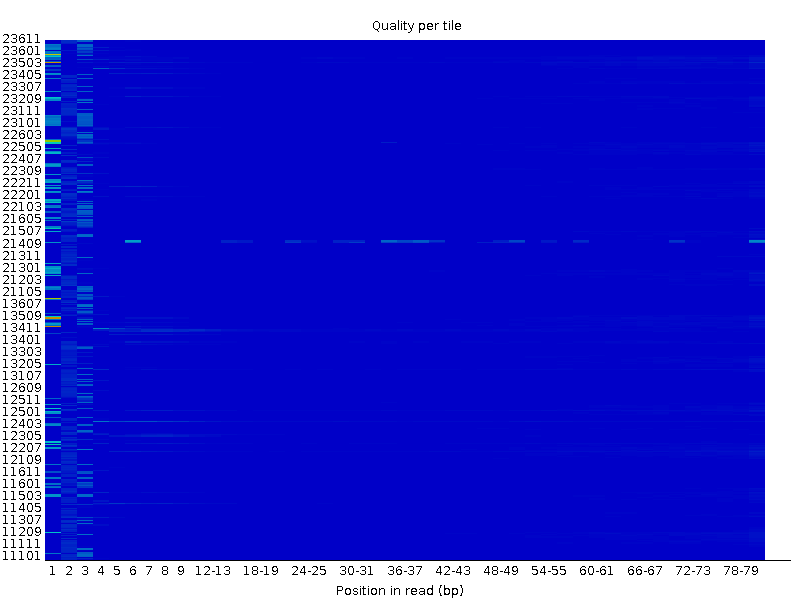

**Per sequence quality scores : pass**

**Per base sequence content : fail**

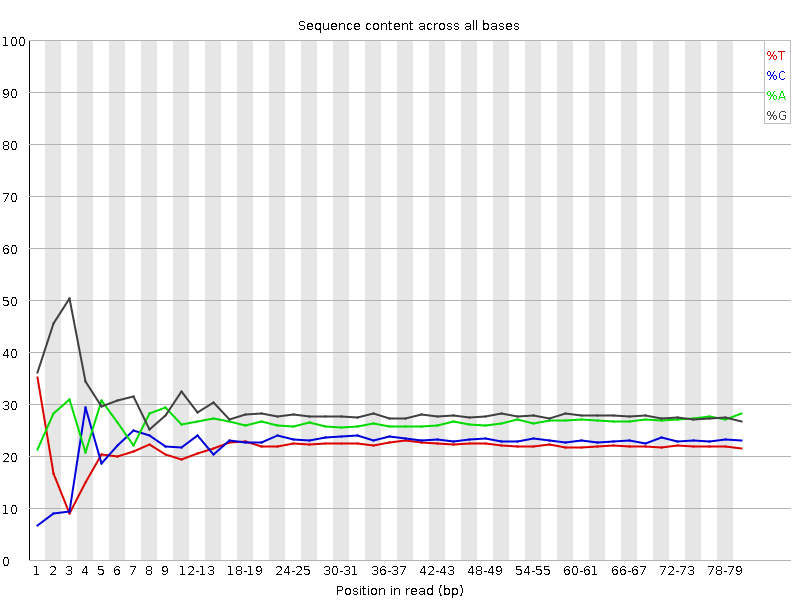

**Per sequence GC content : warn**

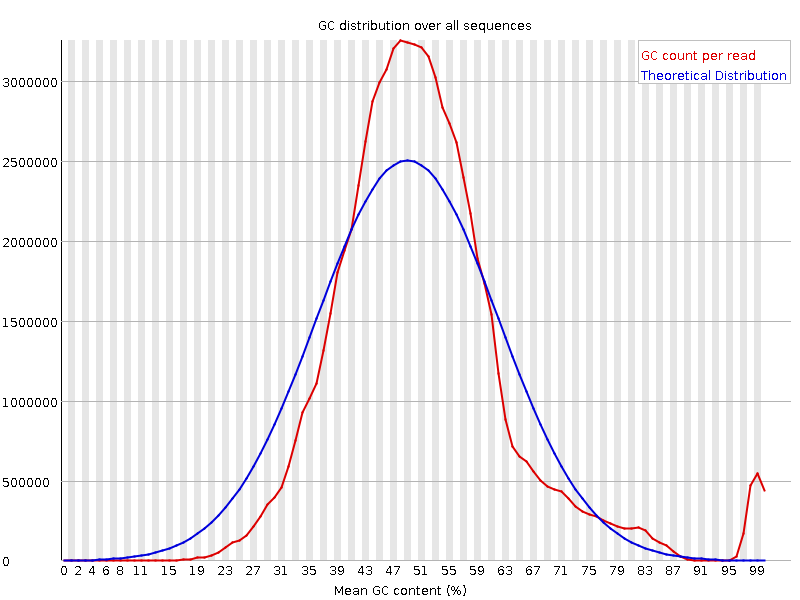

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : warn**

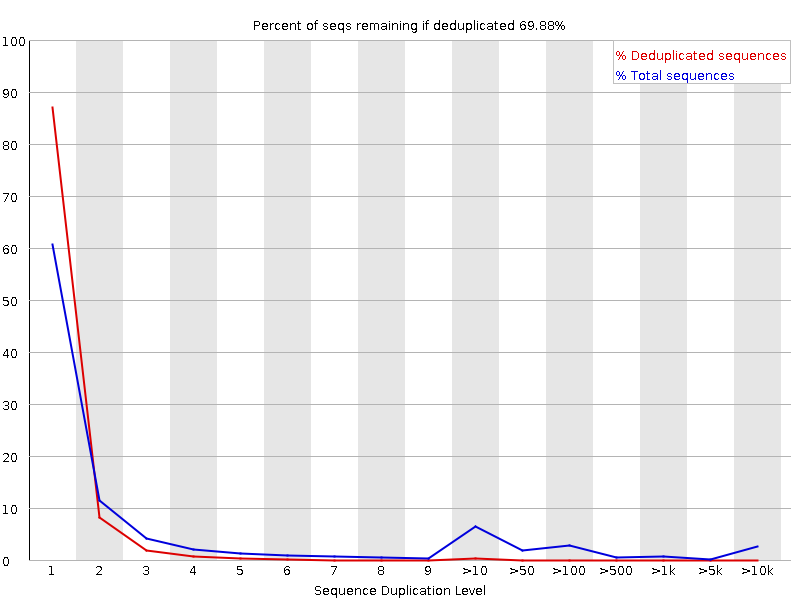

**Overrepresented sequences : warn**

**Adapter Content : warn**

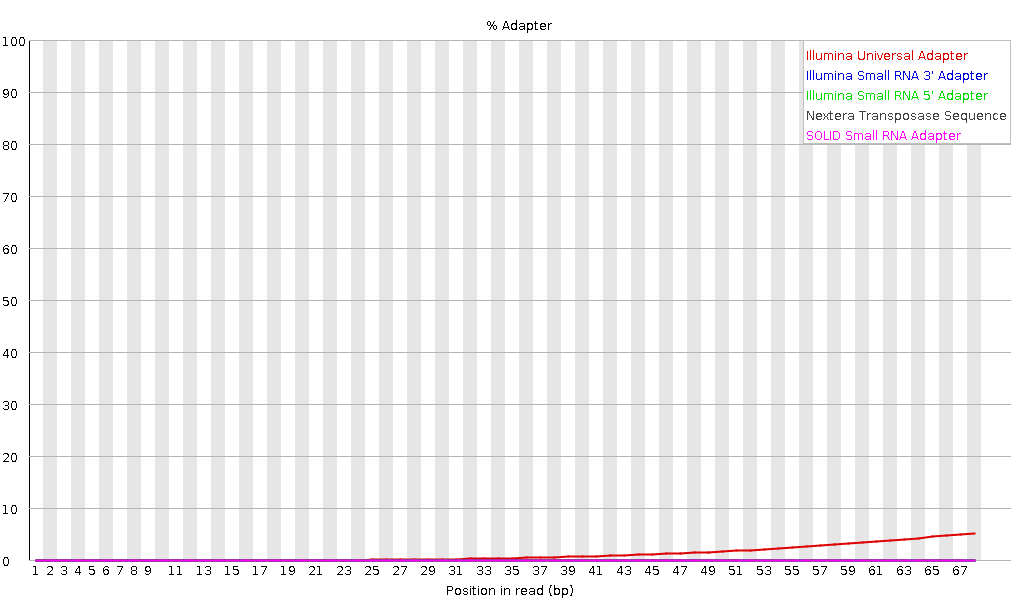

**Kmer Content : fail**

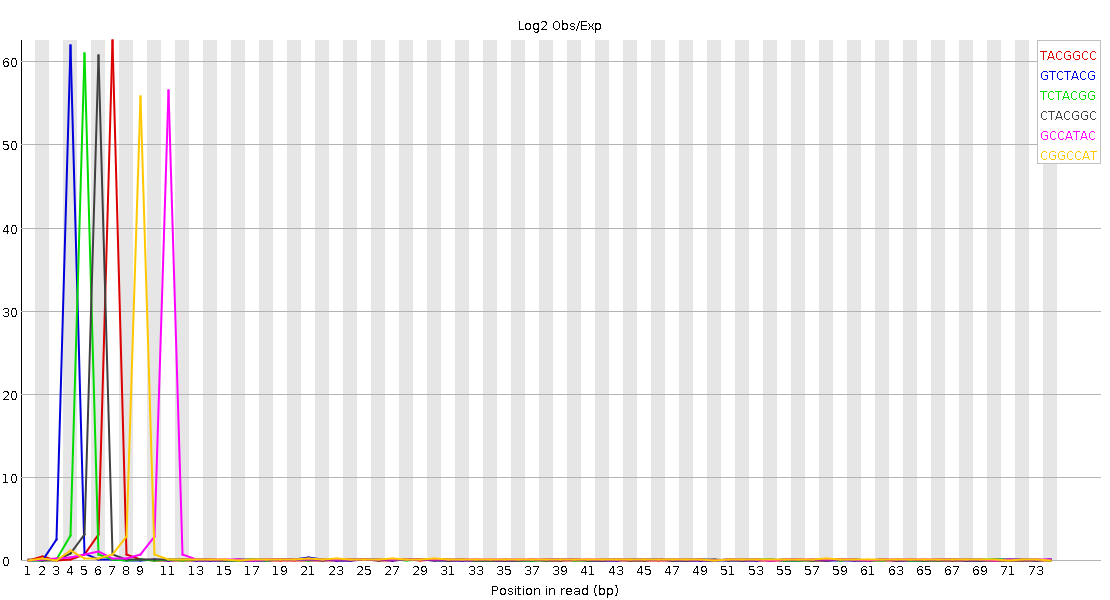

---
## 41IIR_2_fastqc.zip

**Basic Statistics : pass**

**Per base sequence quality : pass**

**Per tile sequence quality : warn**

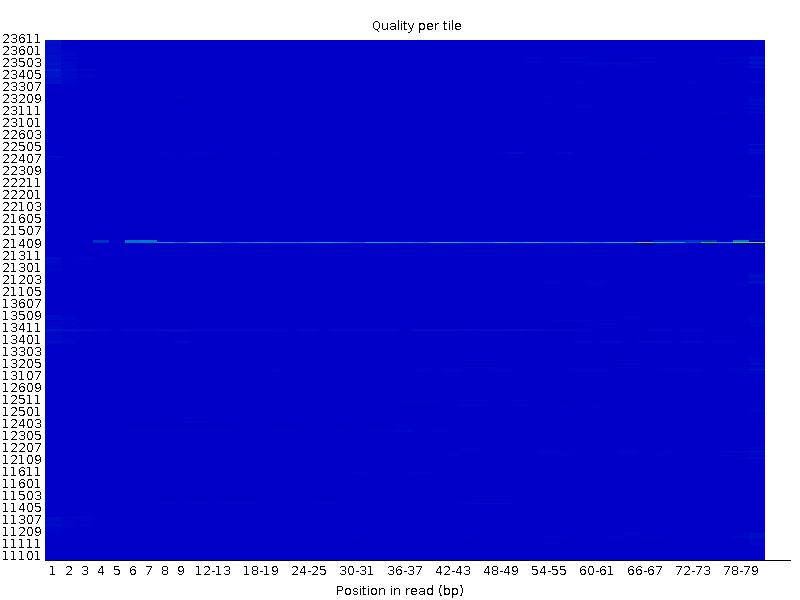

**Per sequence quality scores : pass**

**Per base sequence content : fail**

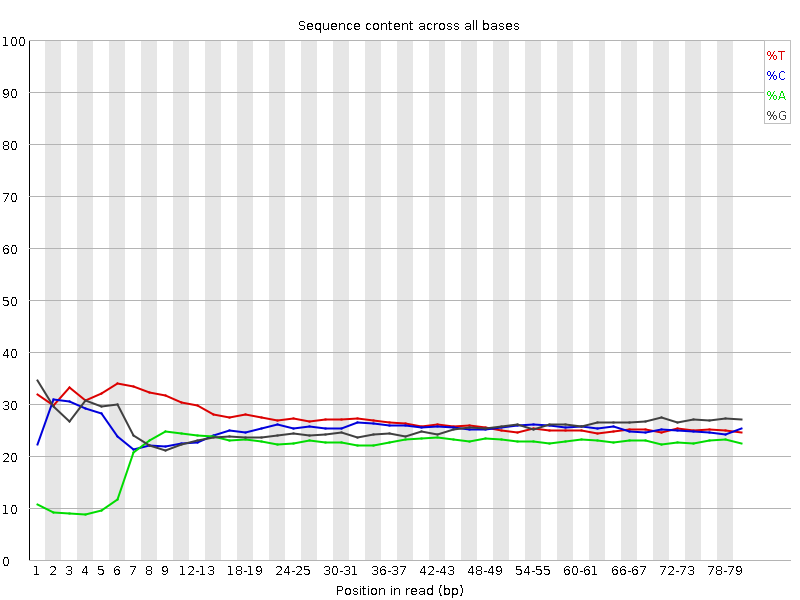

**Per sequence GC content : warn**

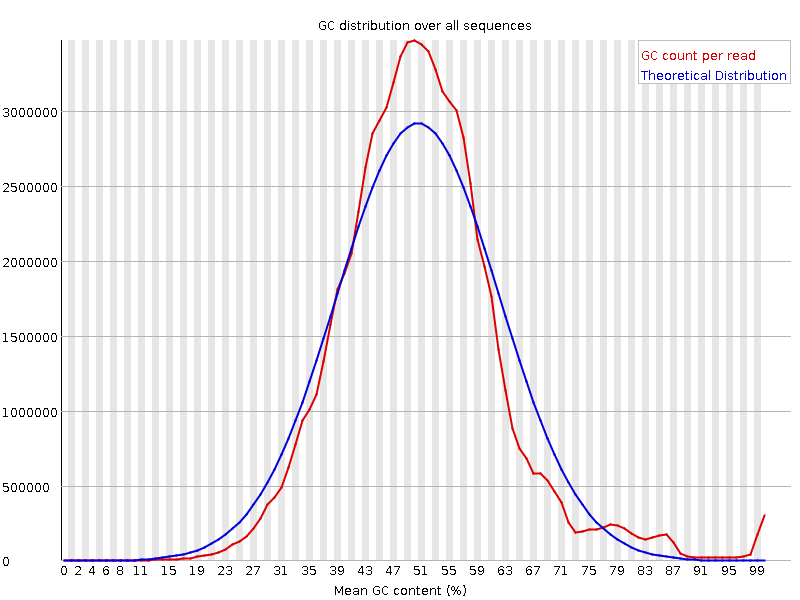

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : fail**

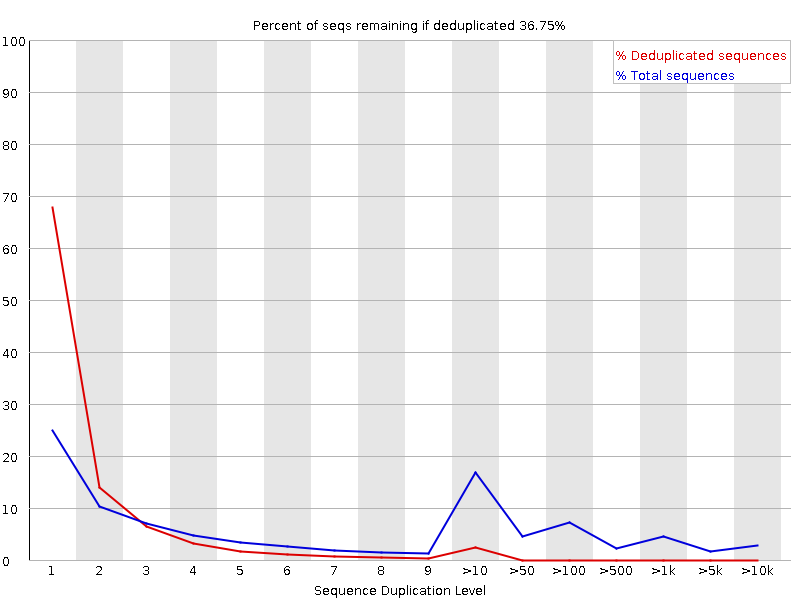

**Overrepresented sequences : warn**

**Adapter Content : warn**

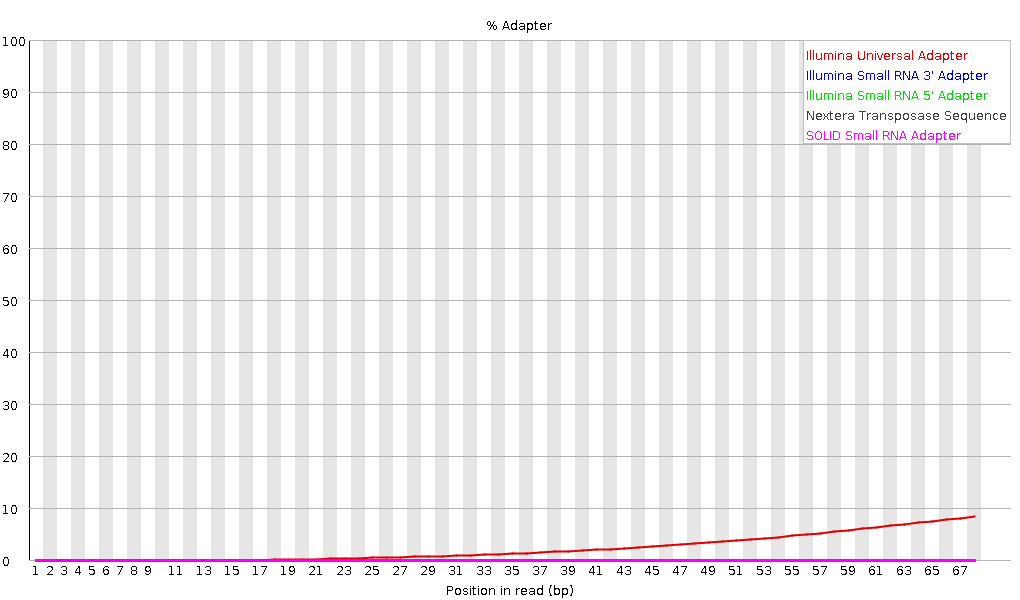

**Kmer Content : fail**

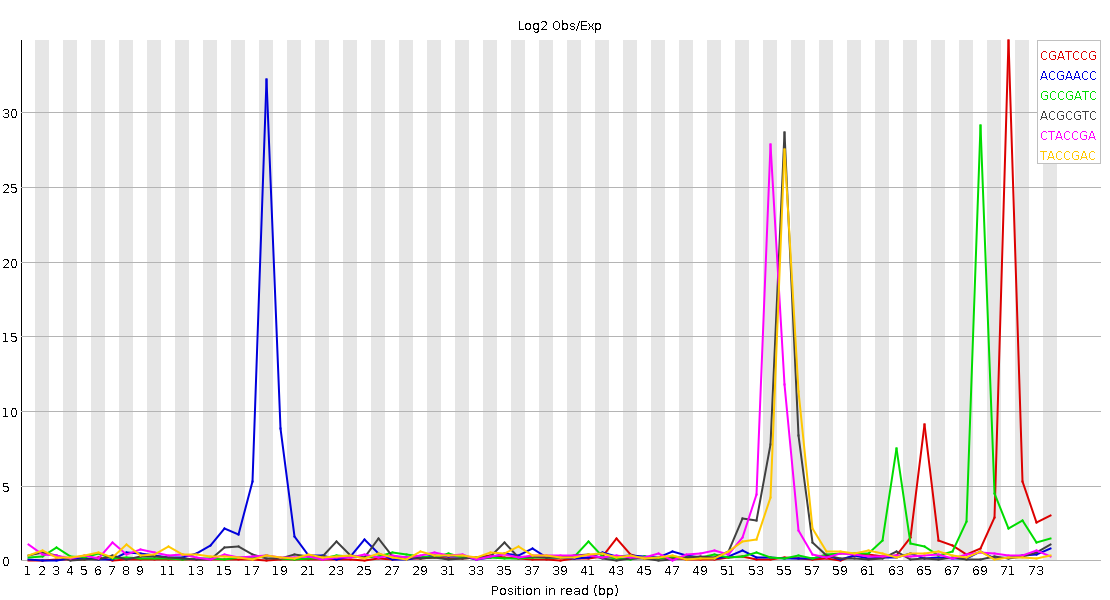

---
## 42IIR_2_fastqc.zip

**Basic Statistics : pass**

**Per base sequence quality : pass**

**Per tile sequence quality : warn**

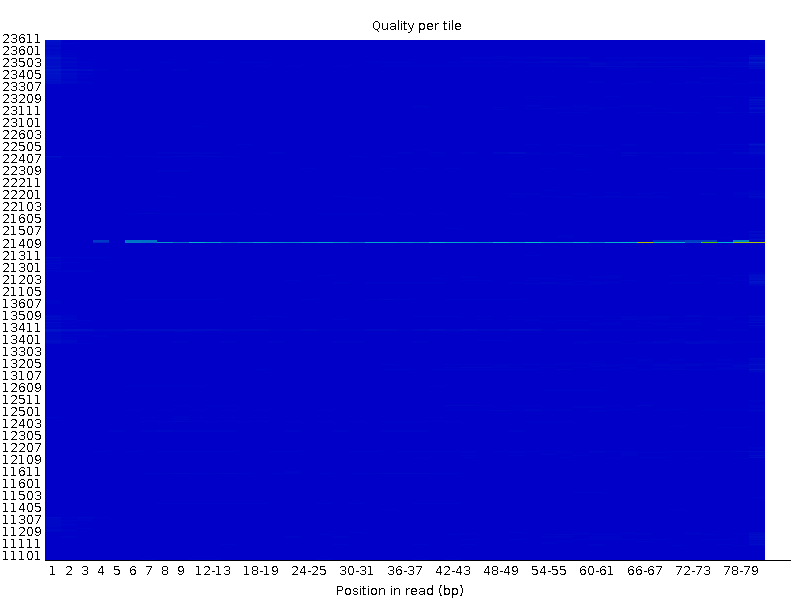

**Per sequence quality scores : pass**

**Per base sequence content : fail**

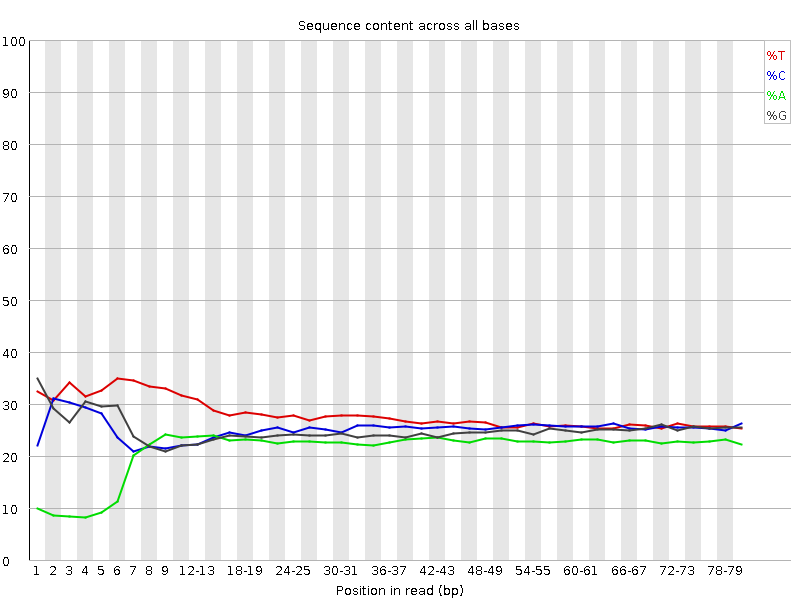

**Per sequence GC content : warn**

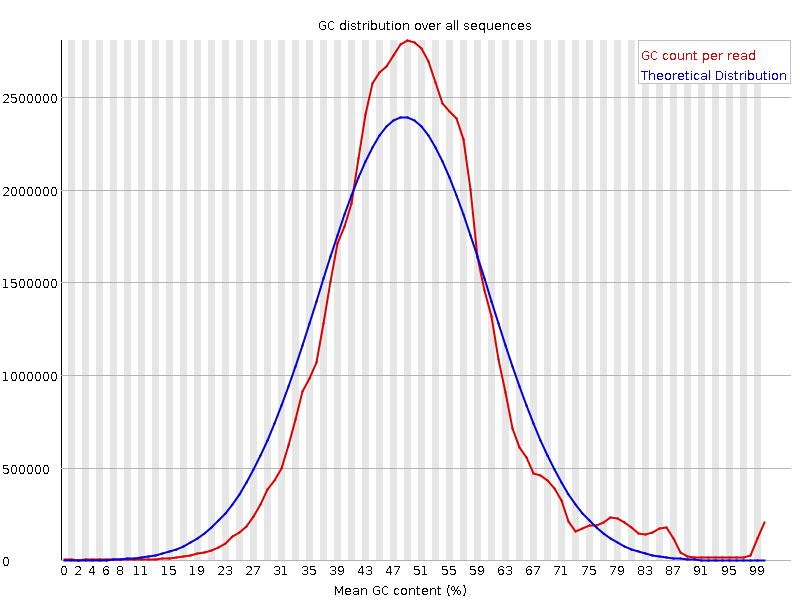

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : fail**

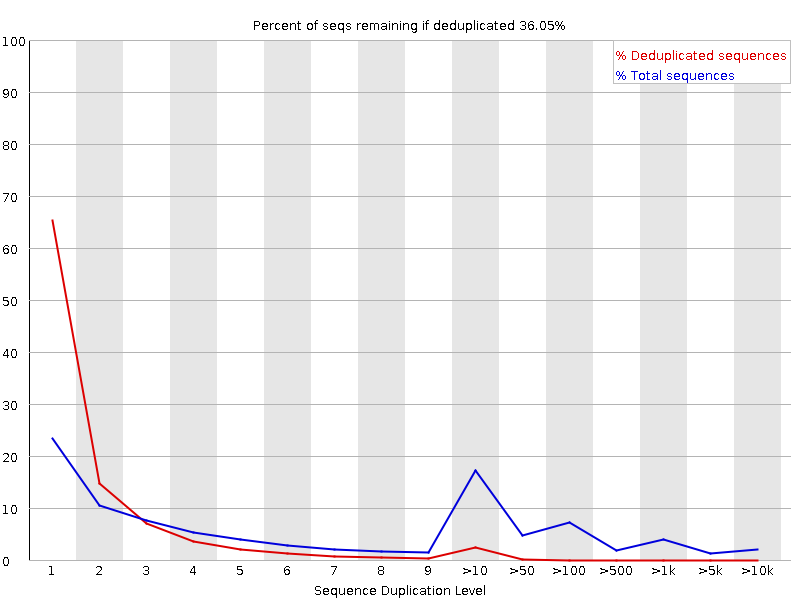

**Overrepresented sequences : warn**

**Adapter Content : pass**

**Kmer Content : fail**

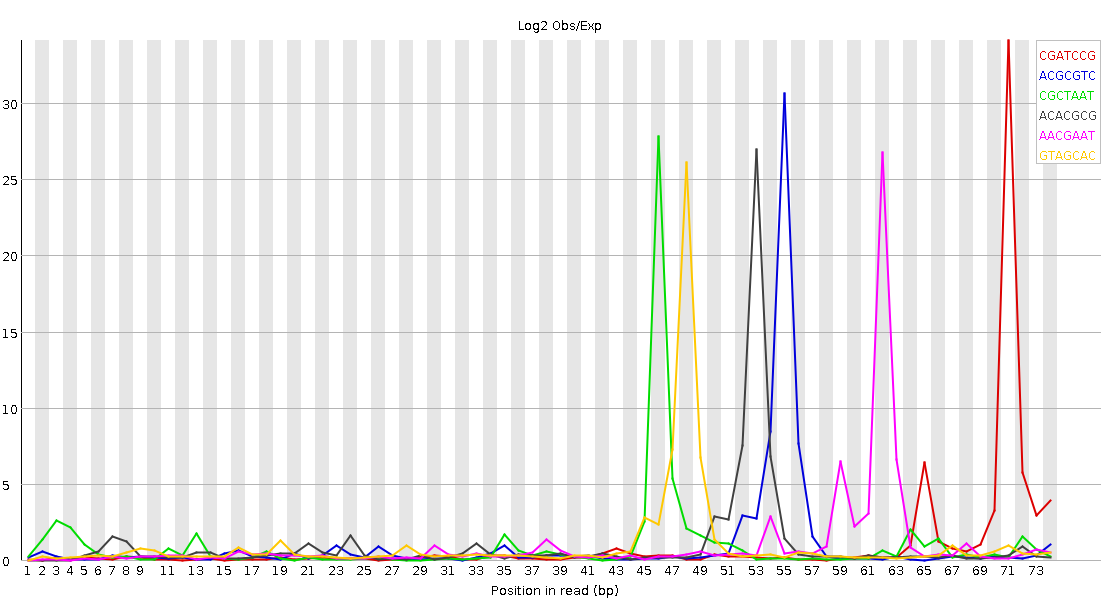

---
## 27IIR_2_fastqc.zip

**Basic Statistics : pass**

**Per base sequence quality : pass**

**Per tile sequence quality : warn**

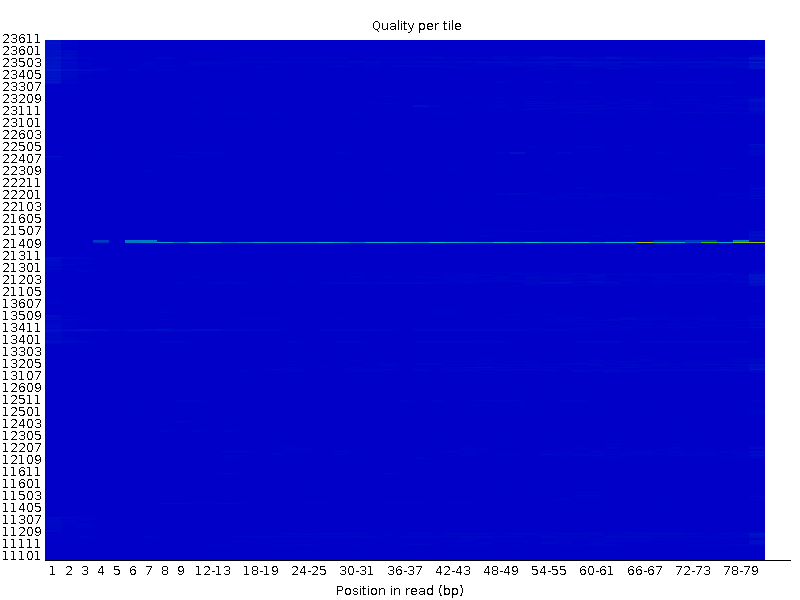

**Per sequence quality scores : pass**

**Per base sequence content : fail**

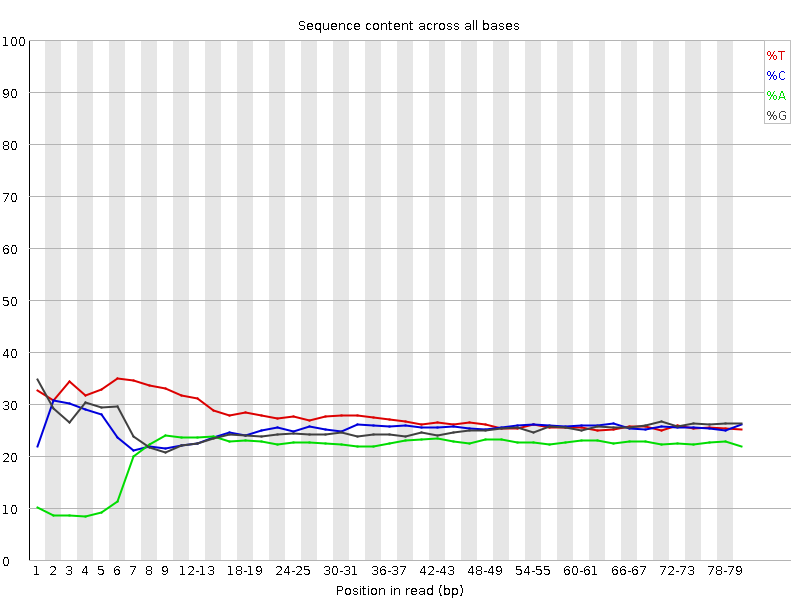

**Per sequence GC content : warn**

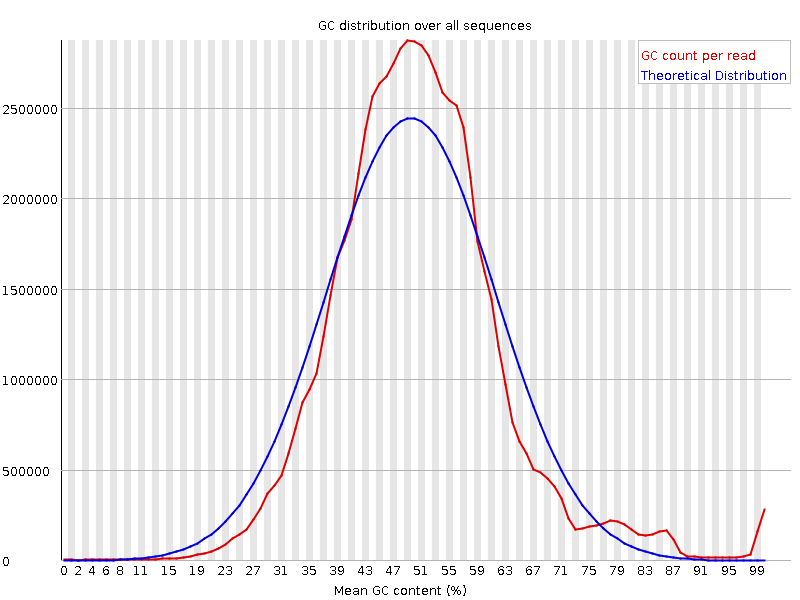

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : fail**

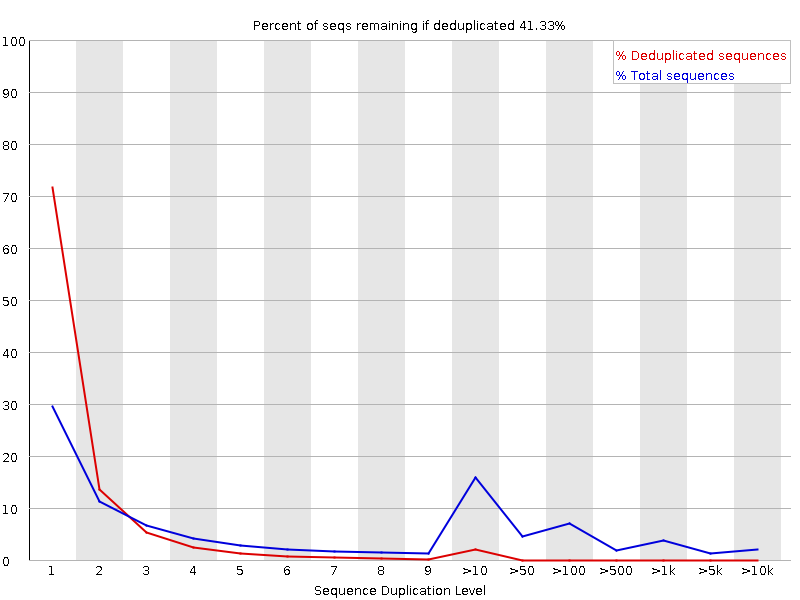

**Overrepresented sequences : warn**

**Adapter Content : pass**

**Kmer Content : fail**

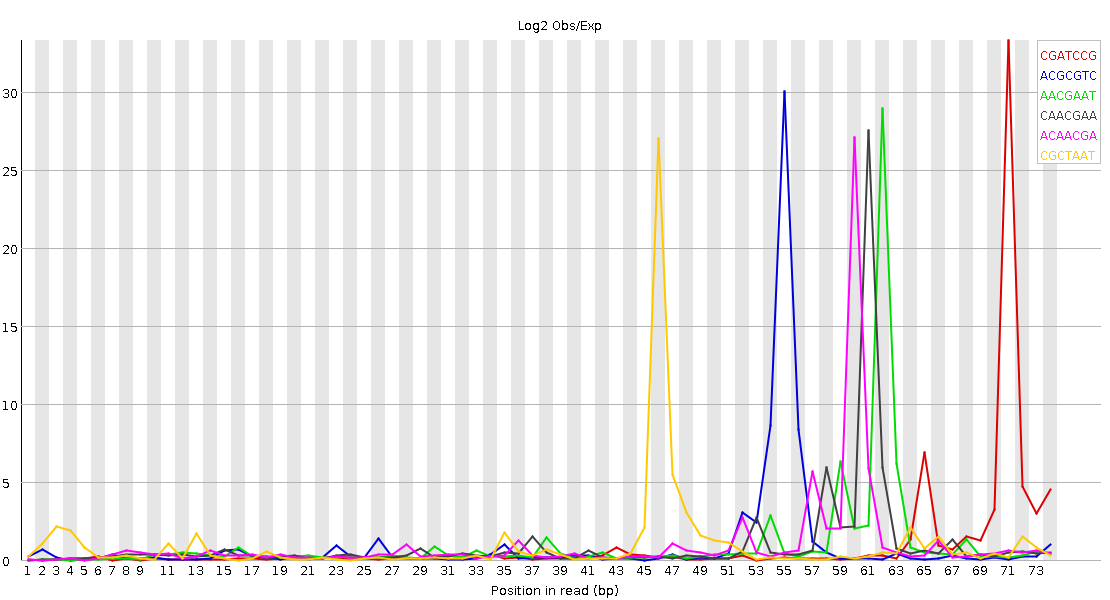

---
## 32IIR_1_fastqc.zip

**Basic Statistics : pass**

**Per base sequence quality : pass**

**Per tile sequence quality : warn**

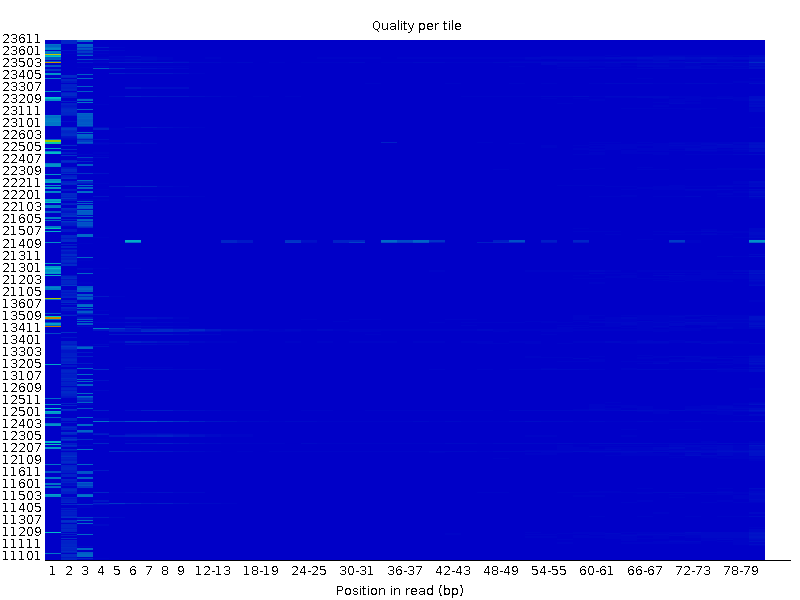

**Per sequence quality scores : pass**

**Per base sequence content : fail**

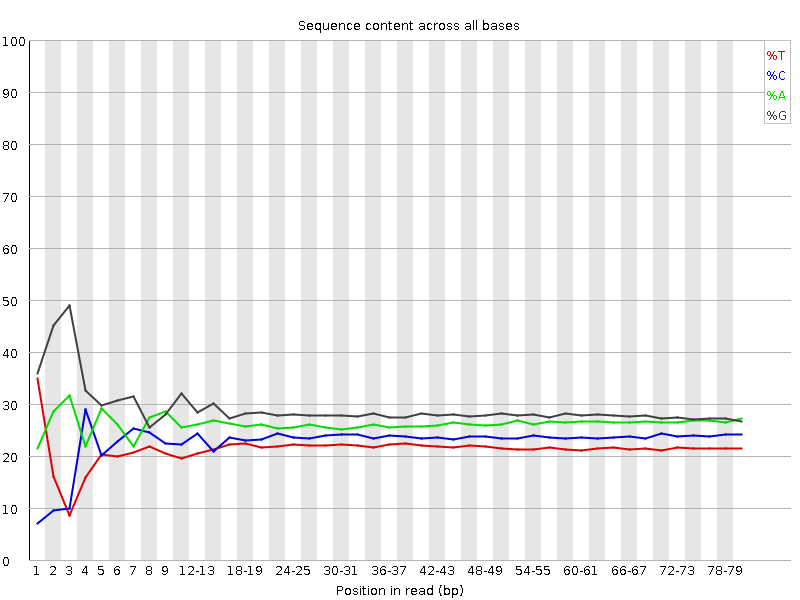

**Per sequence GC content : warn**

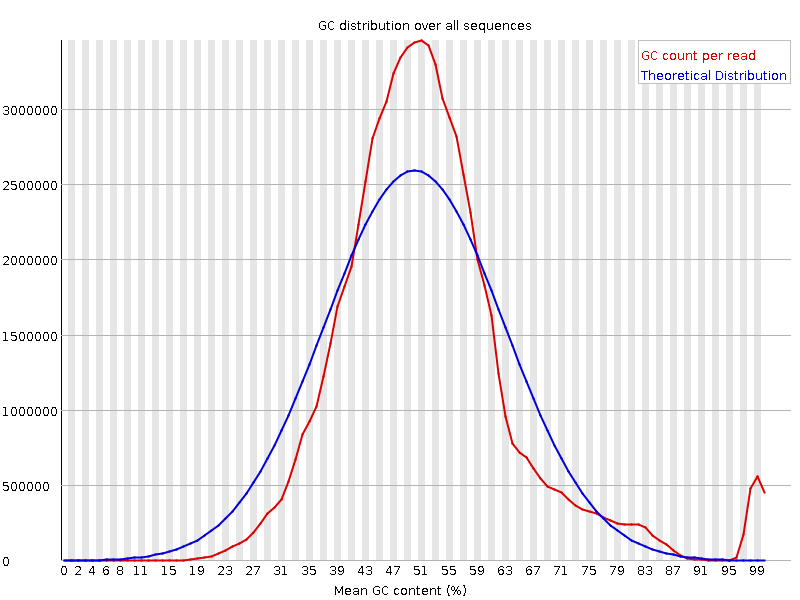

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : warn**

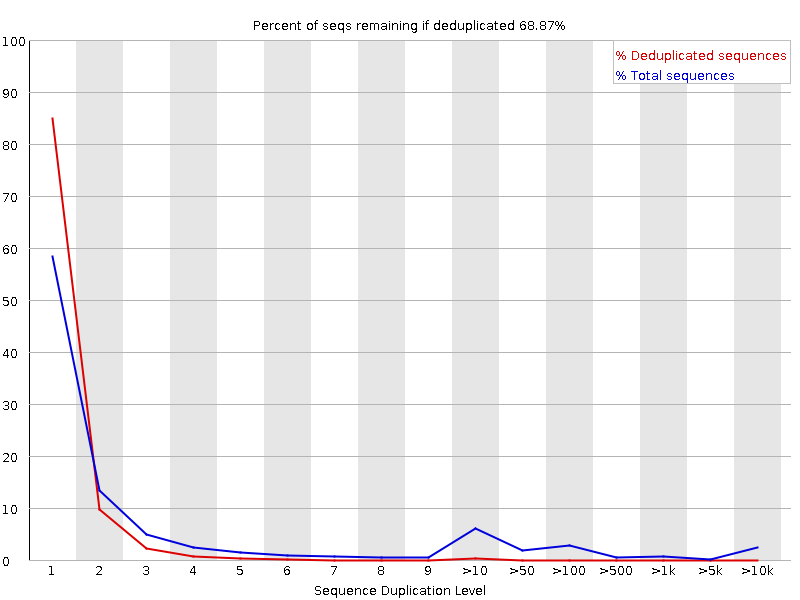

**Overrepresented sequences : warn**

**Adapter Content : warn**

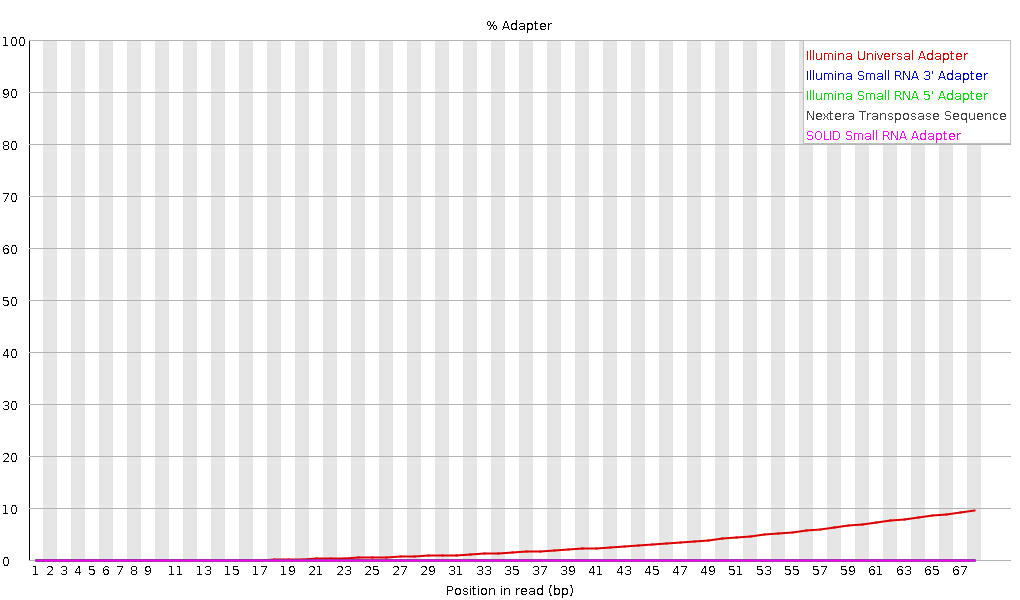

**Kmer Content : fail**

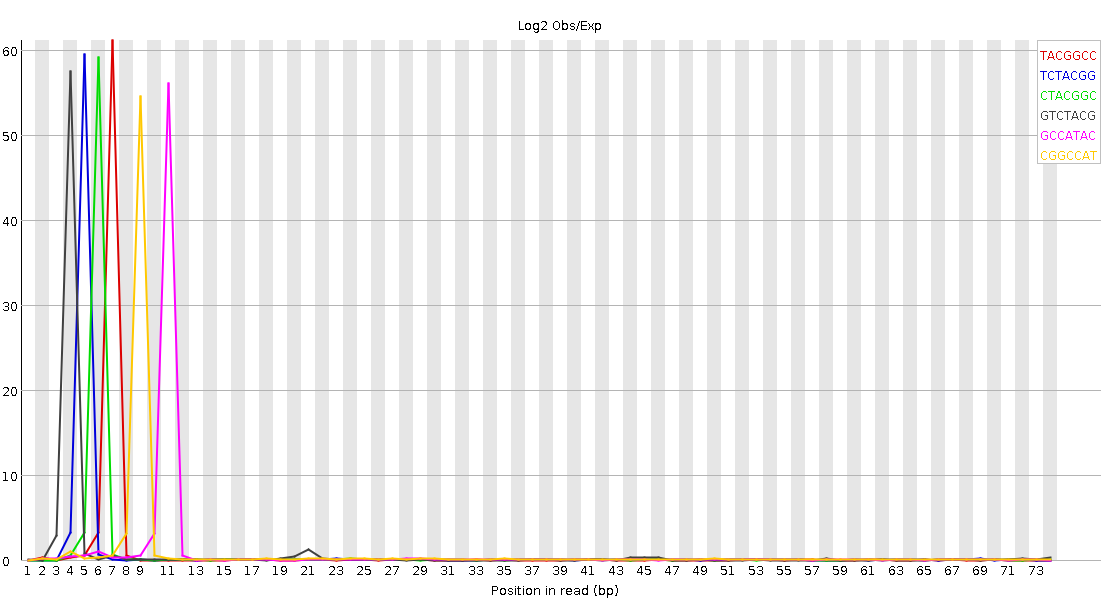

---
## 27IIR_1_fastqc.zip

**Basic Statistics : pass**

**Per base sequence quality : pass**

**Per tile sequence quality : warn**

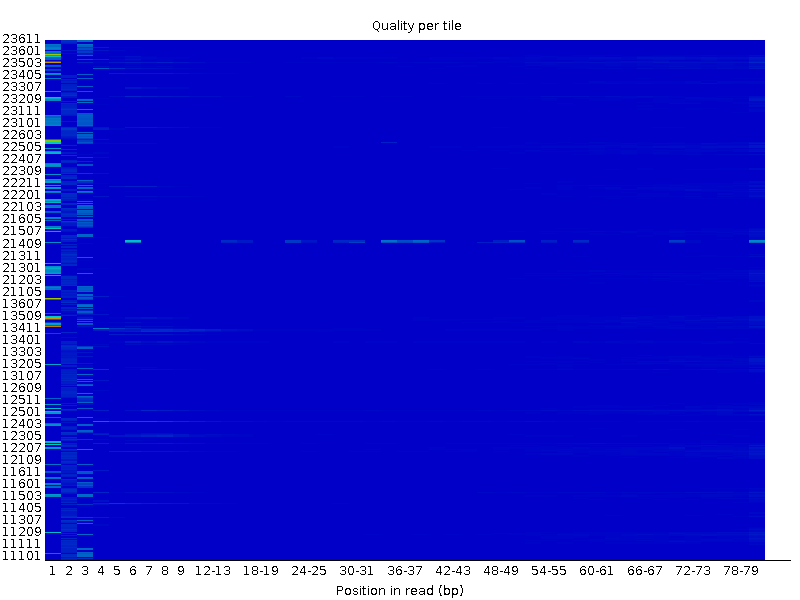

**Per sequence quality scores : pass**

**Per base sequence content : fail**

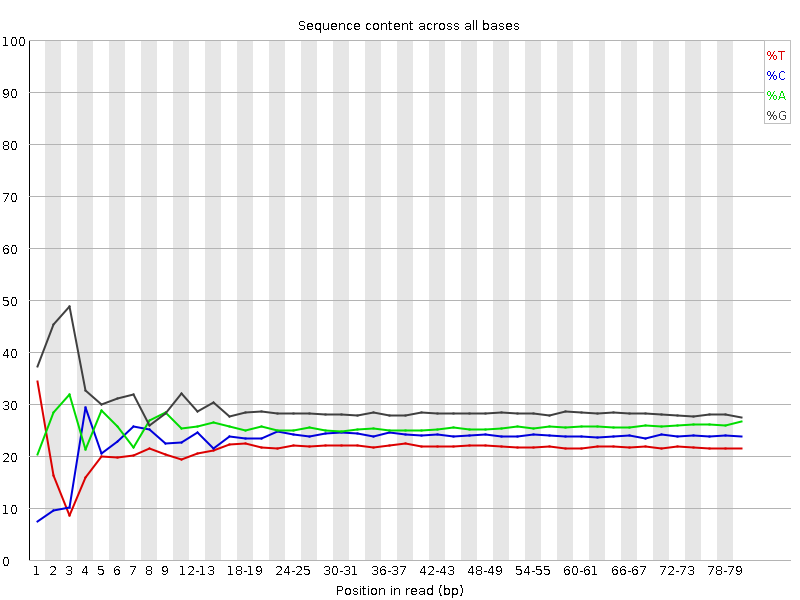

**Per sequence GC content : warn**

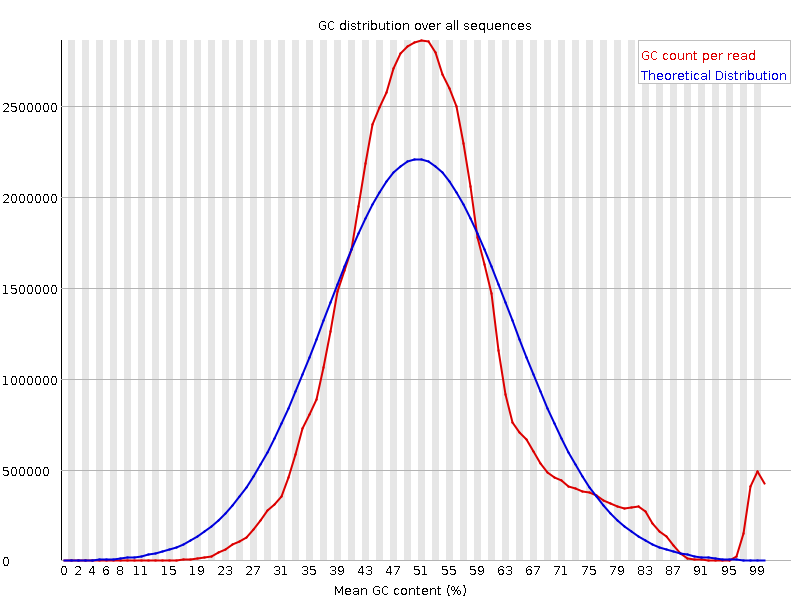

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : pass**

**Overrepresented sequences : warn**

**Adapter Content : pass**

**Kmer Content : fail**

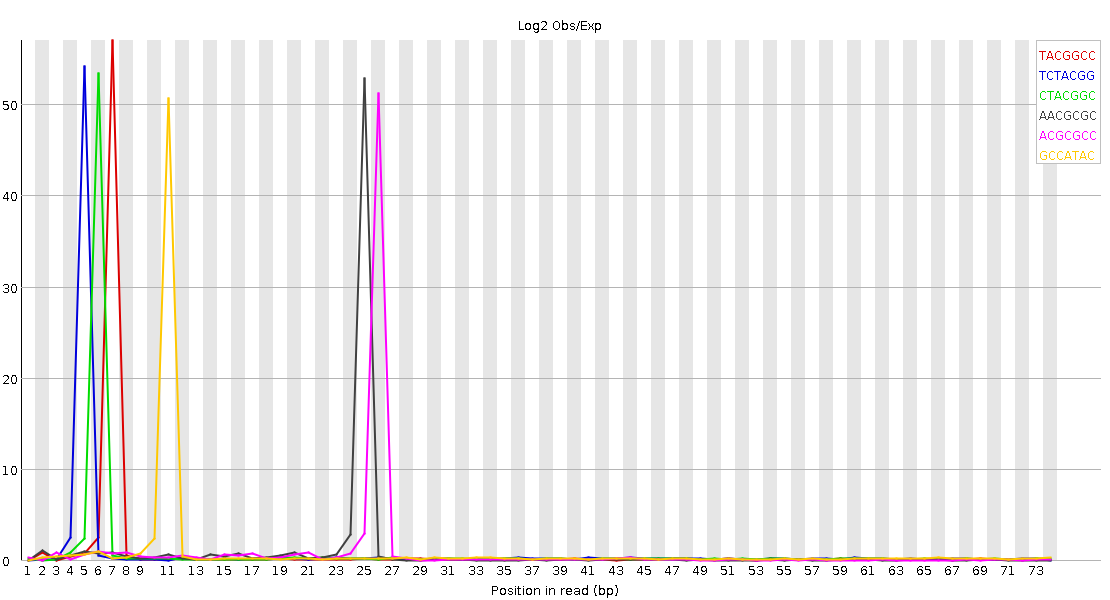

---
## 26IIR_2_fastqc.zip

**Basic Statistics : pass**

**Per base sequence quality : pass**

**Per tile sequence quality : warn**

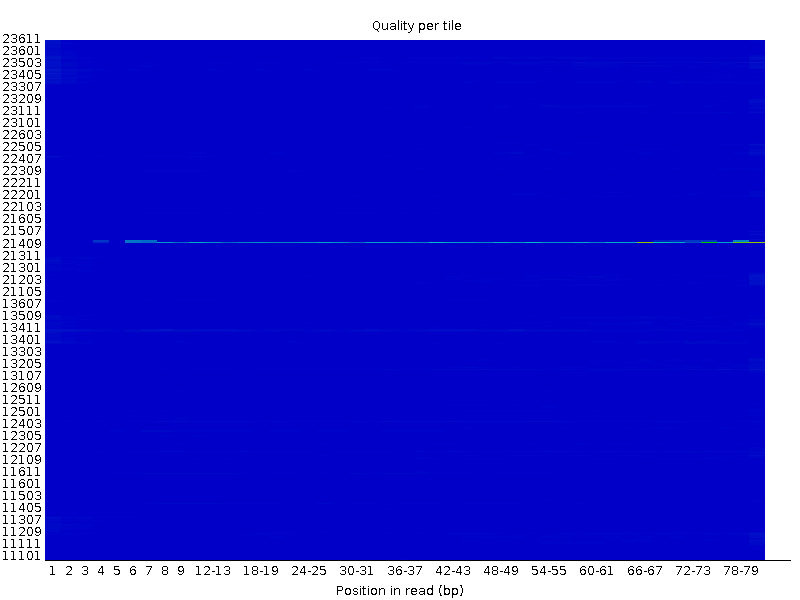

**Per sequence quality scores : pass**

**Per base sequence content : fail**

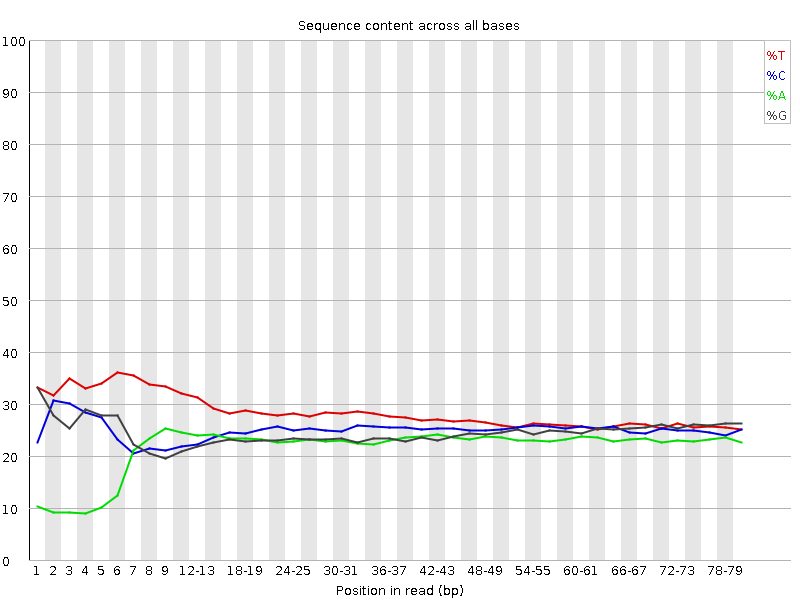

**Per sequence GC content : warn**

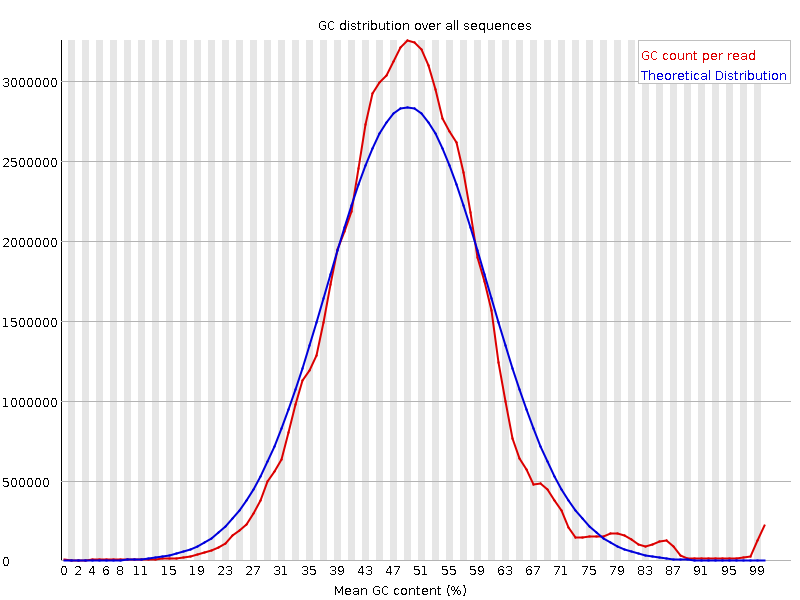

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : fail**

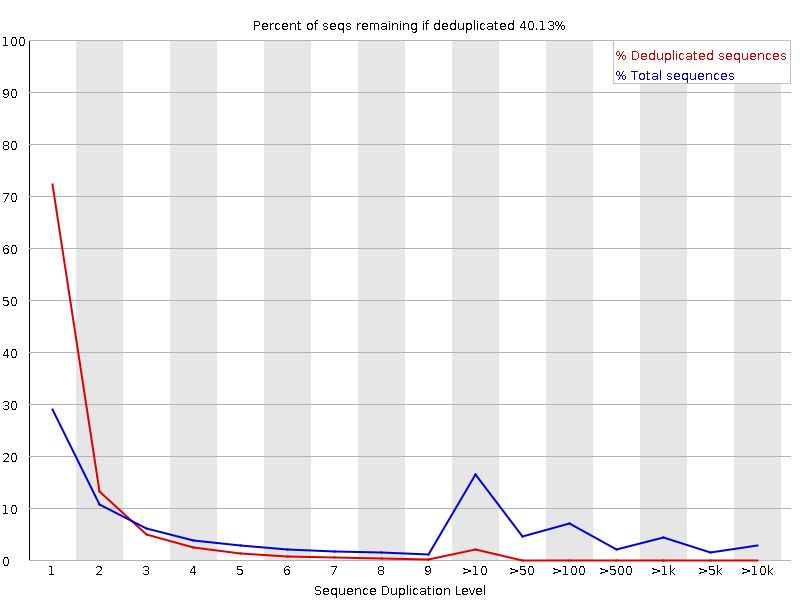

**Overrepresented sequences : warn**

**Adapter Content : warn**

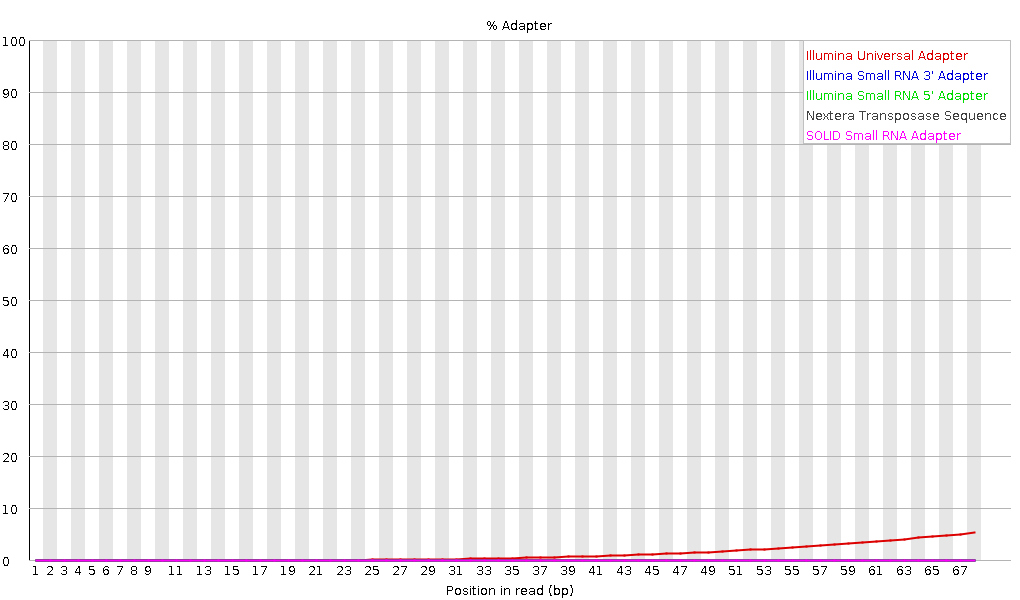

**Kmer Content : fail**

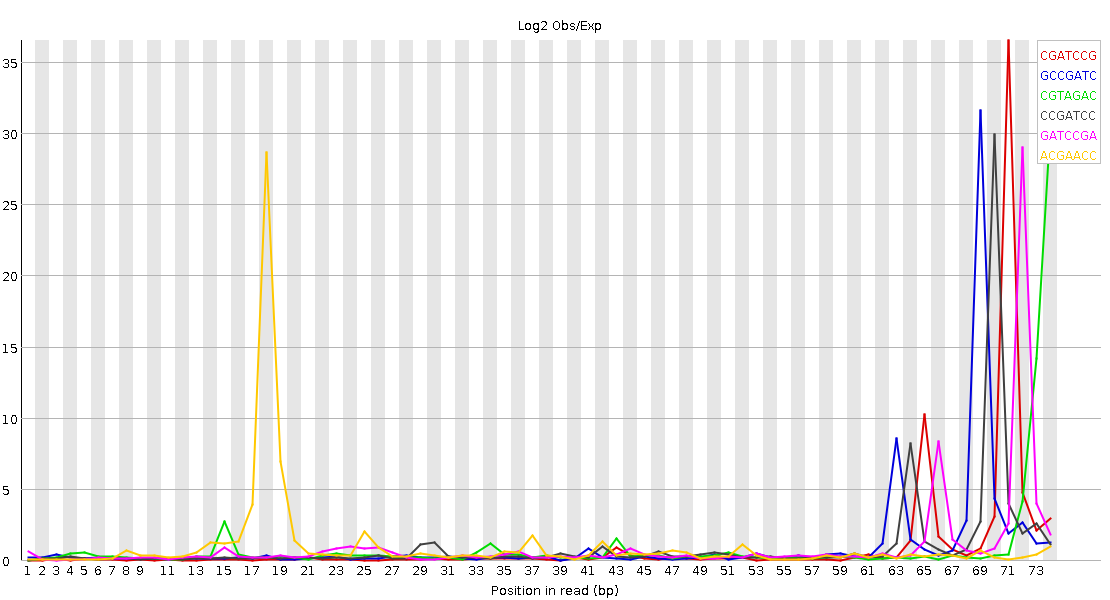

---
## 41IIR_1_fastqc.zip

**Basic Statistics : pass**

**Per base sequence quality : pass**

**Per tile sequence quality : warn**

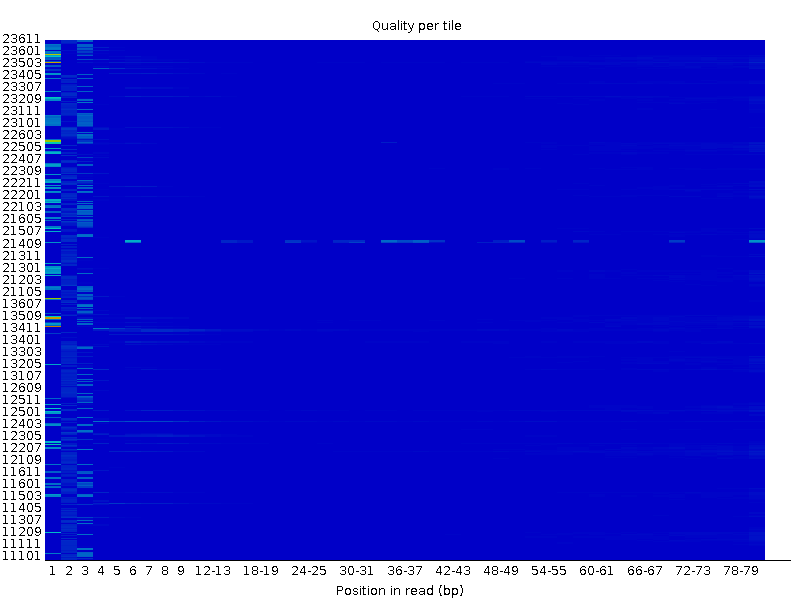

**Per sequence quality scores : pass**

**Per base sequence content : fail**

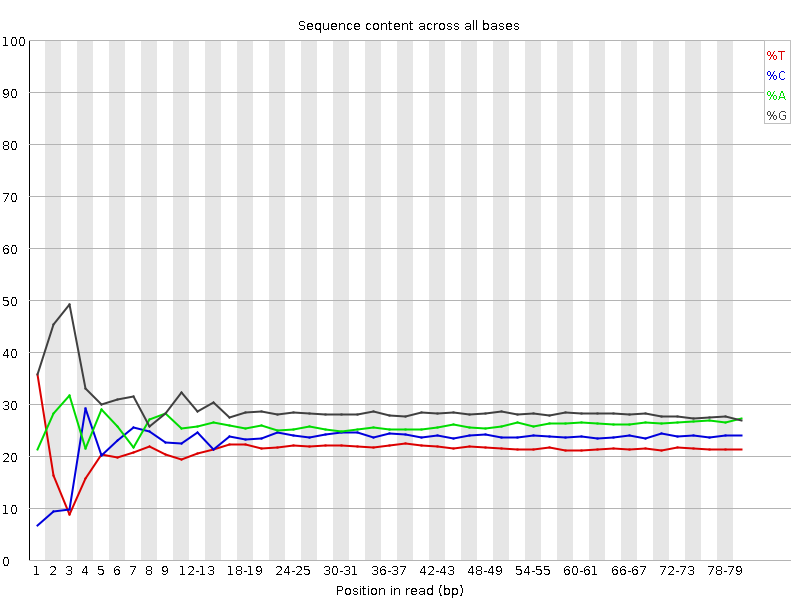

**Per sequence GC content : fail**

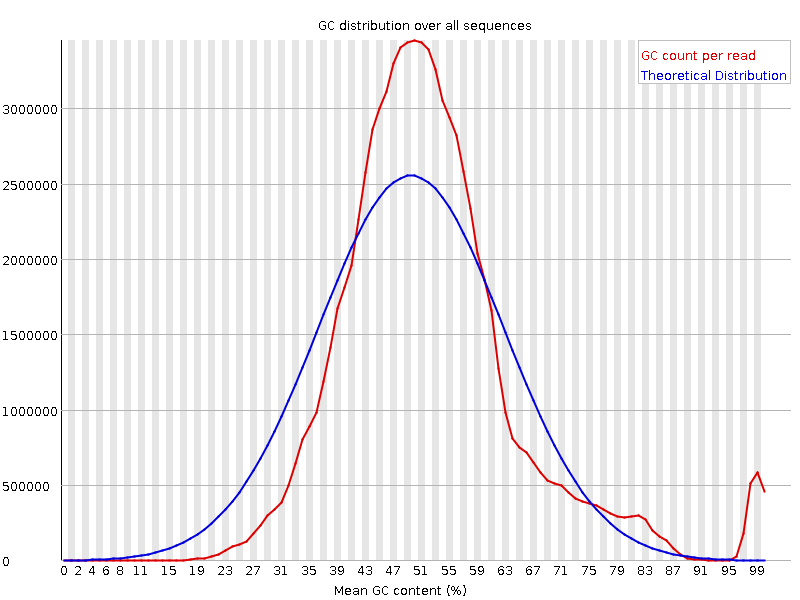

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : warn**

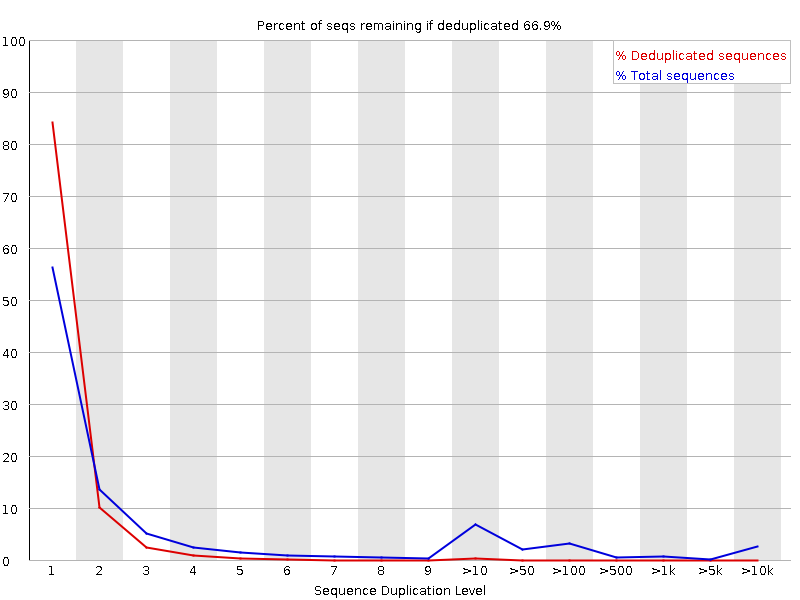

**Overrepresented sequences : warn**

**Adapter Content : warn**

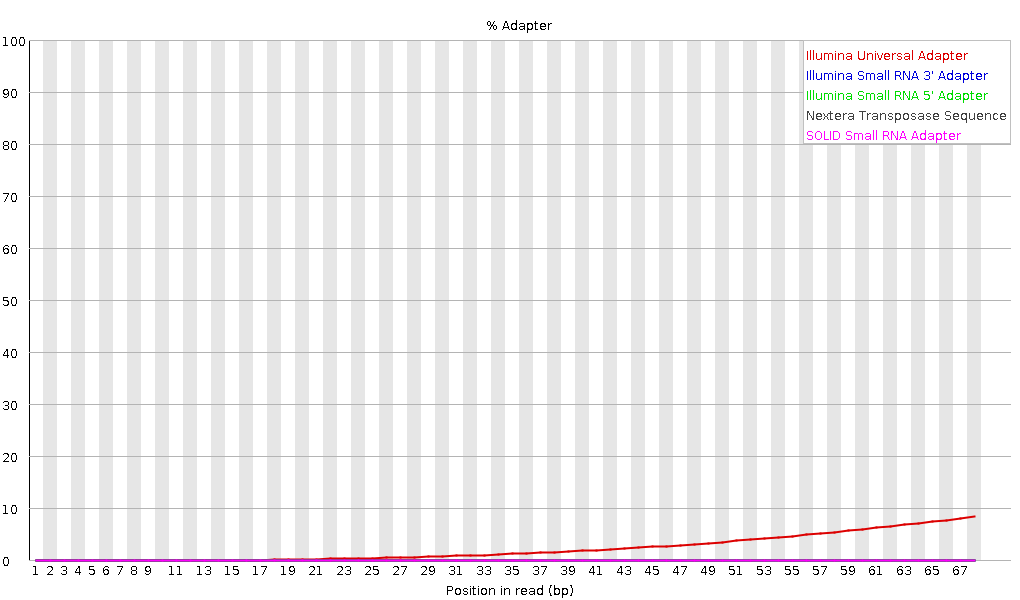

**Kmer Content : fail**

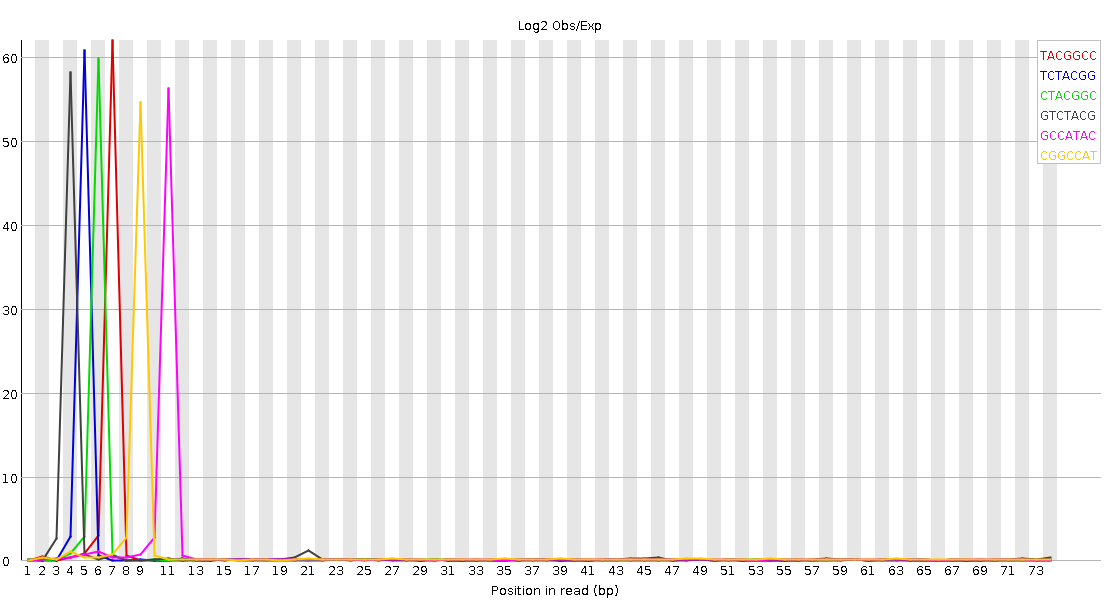

---
## 32IIR_2_fastqc.zip

**Basic Statistics : pass**

**Per base sequence quality : pass**

**Per tile sequence quality : warn**

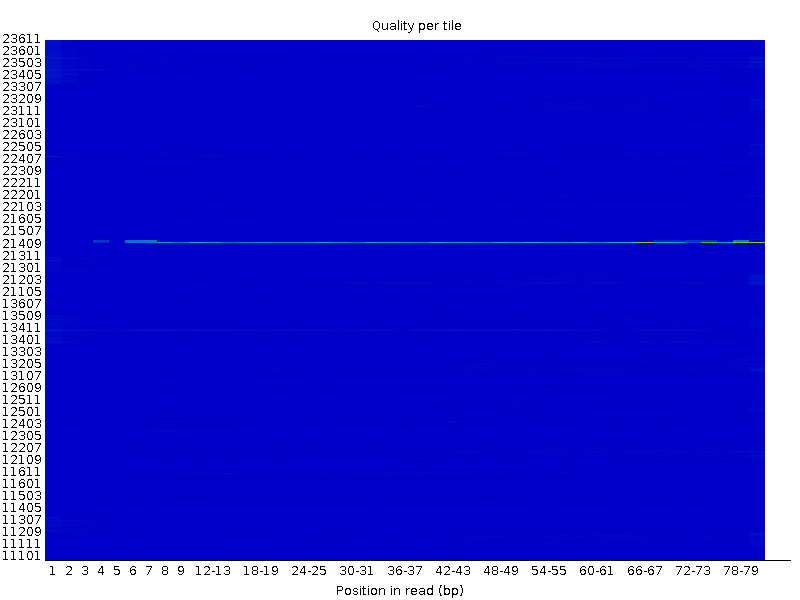

**Per sequence quality scores : pass**

**Per base sequence content : fail**

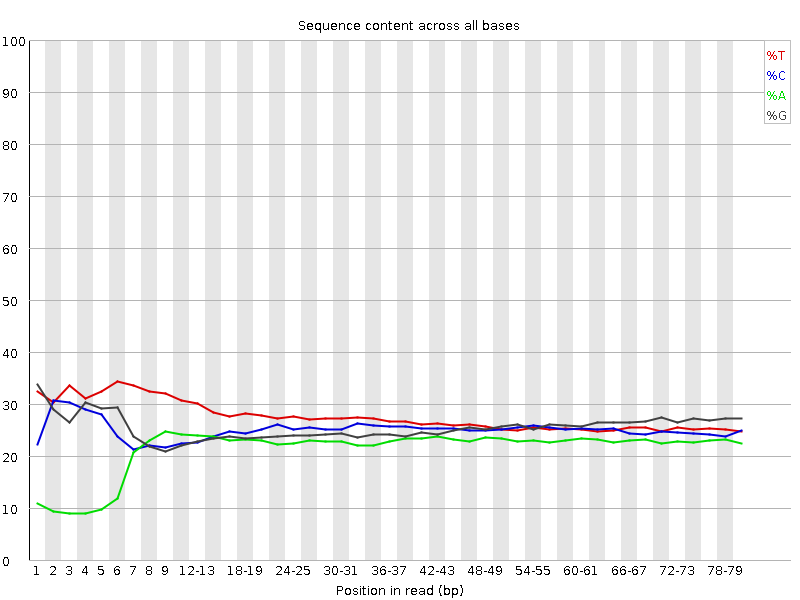

**Per sequence GC content : warn**

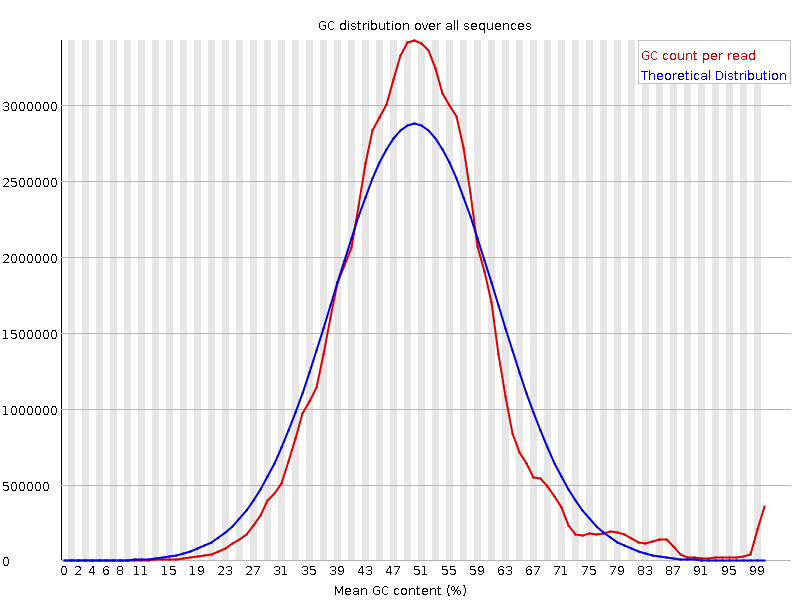

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : fail**

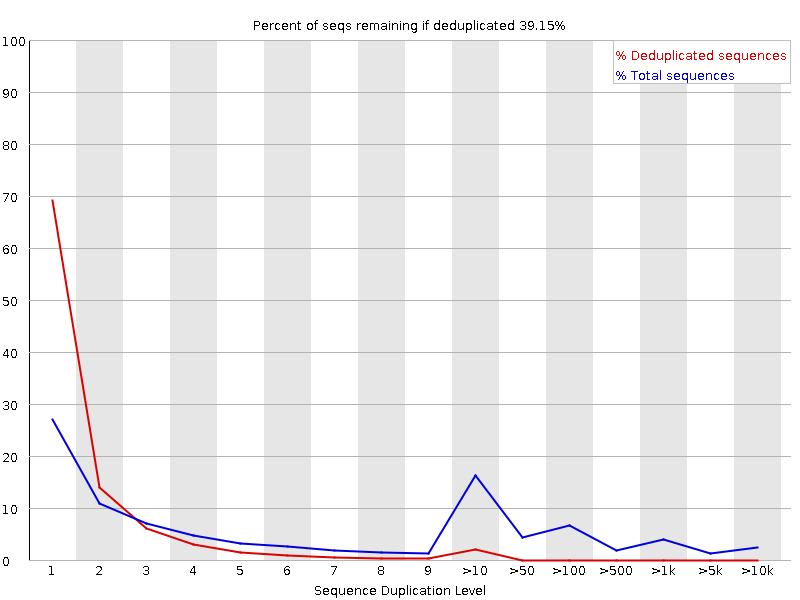

**Overrepresented sequences : warn**

**Adapter Content : warn**

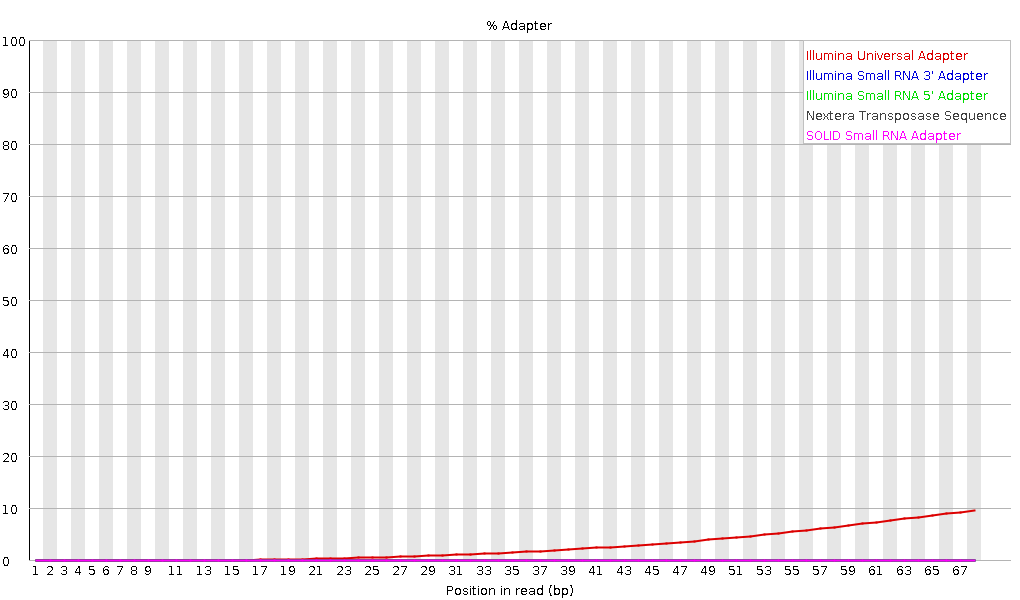

**Kmer Content : fail**

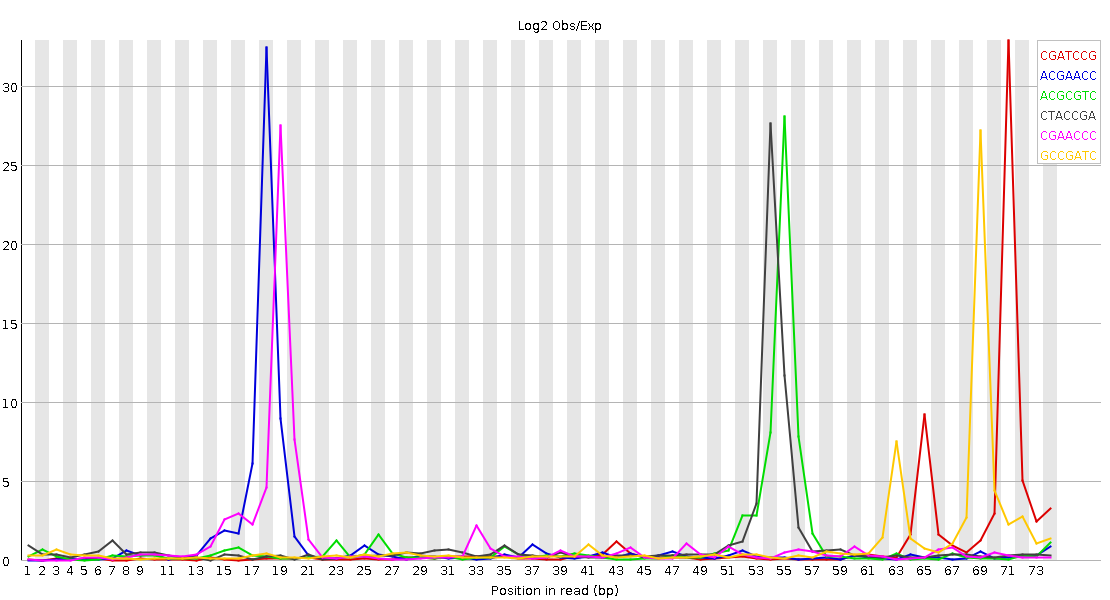

---
## 42IIR_1_fastqc.zip

**Basic Statistics : pass**

**Per base sequence quality : pass**

**Per tile sequence quality : warn**

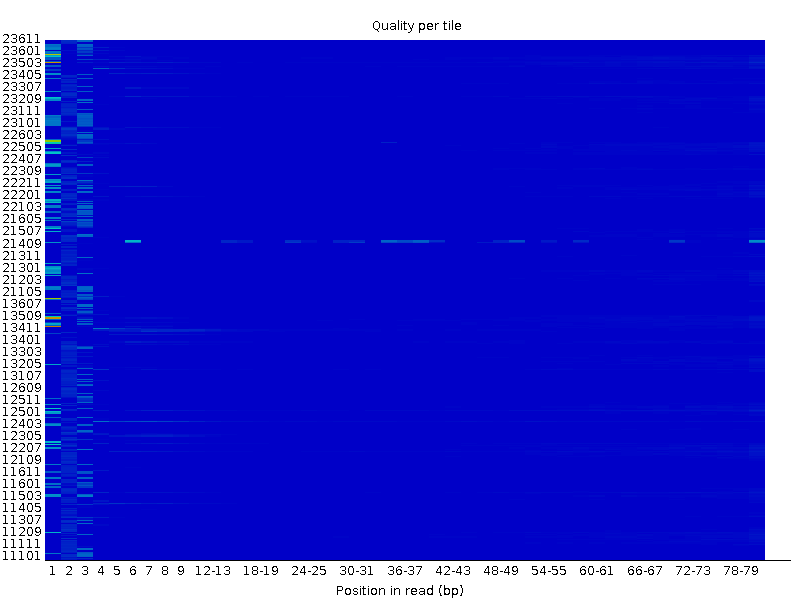

**Per sequence quality scores : pass**

**Per base sequence content : fail**

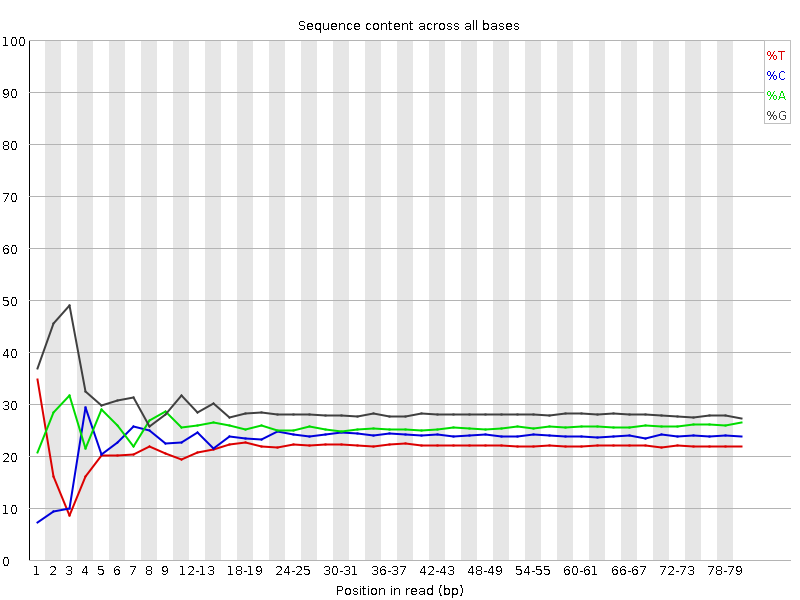

**Per sequence GC content : warn**

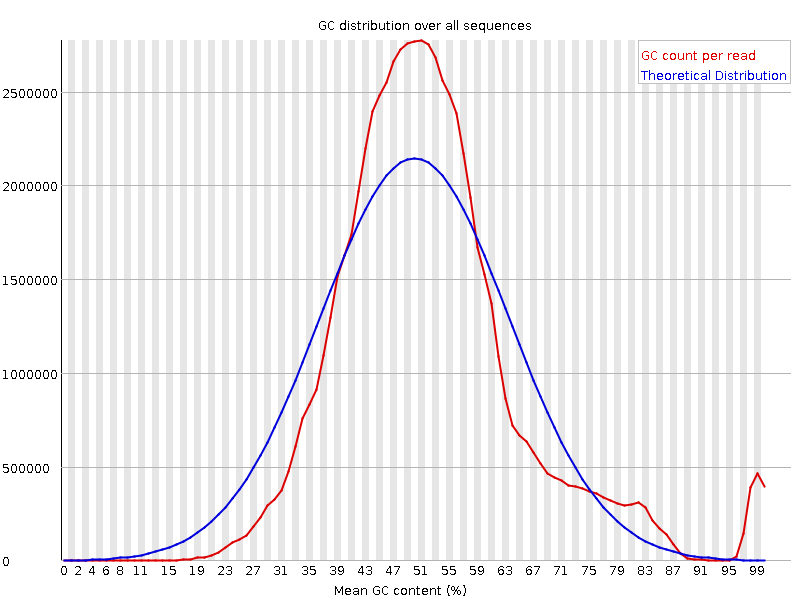

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : warn**

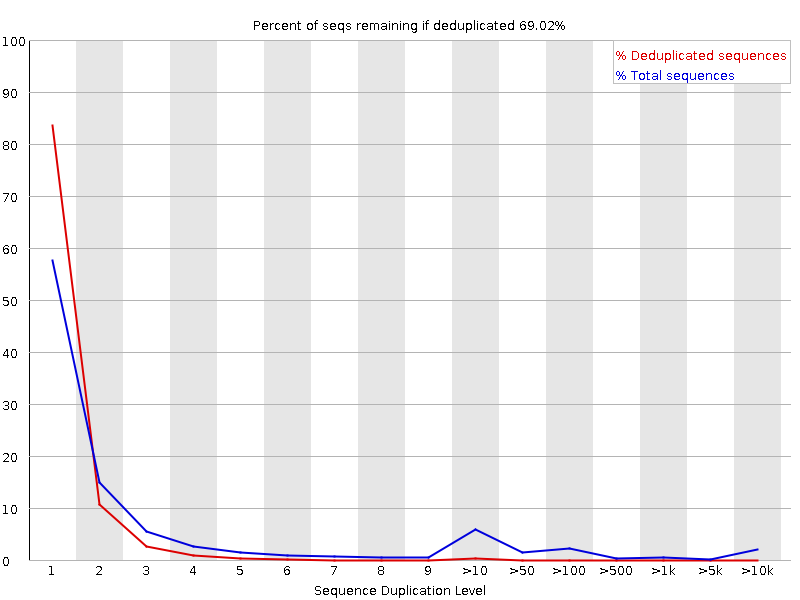

**Overrepresented sequences : warn**

**Adapter Content : pass**

**Kmer Content : fail**

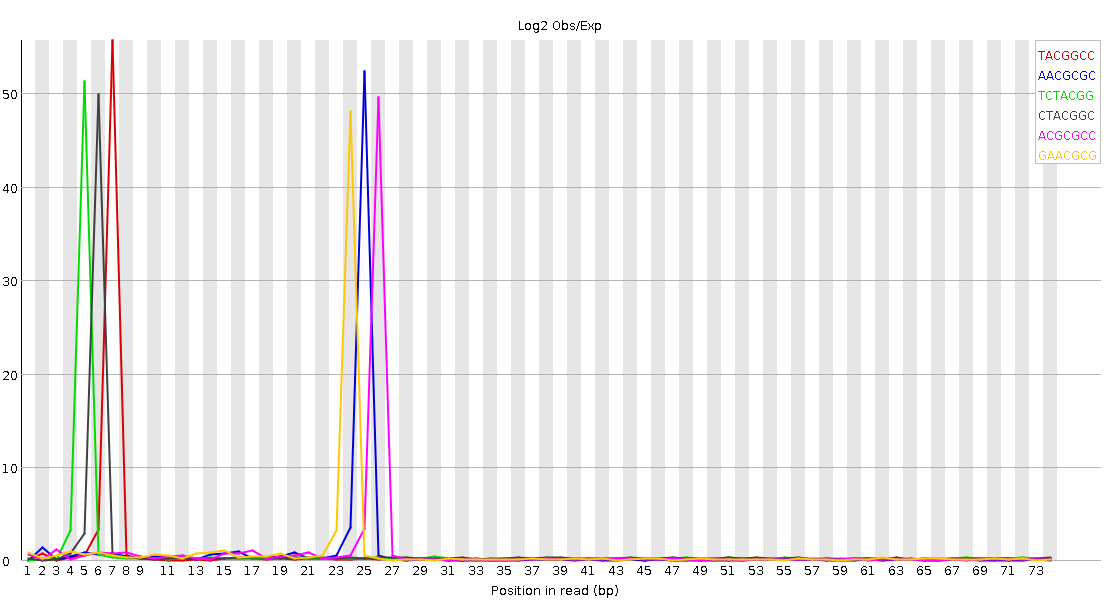

---
## 40IIR_1_fastqc.zip

**Basic Statistics : pass**

**Per base sequence quality : pass**

**Per tile sequence quality : warn**

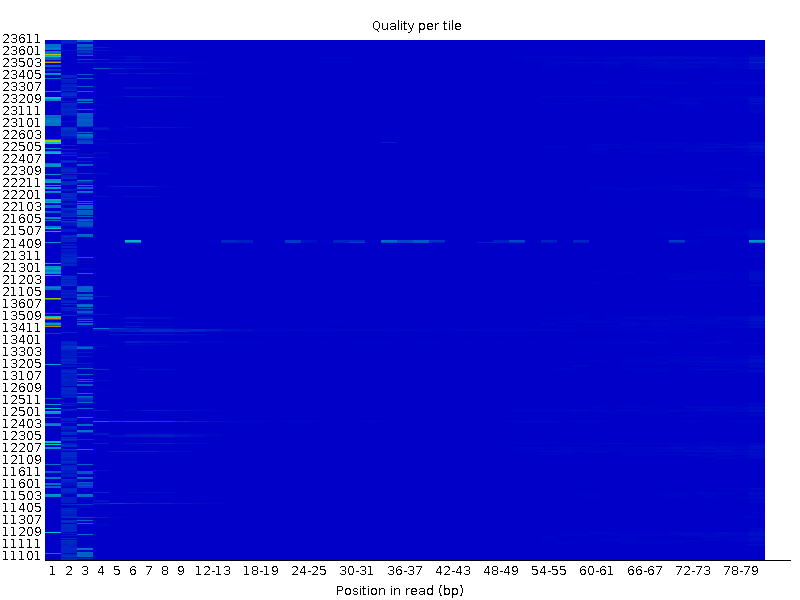

**Per sequence quality scores : pass**

**Per base sequence content : fail**

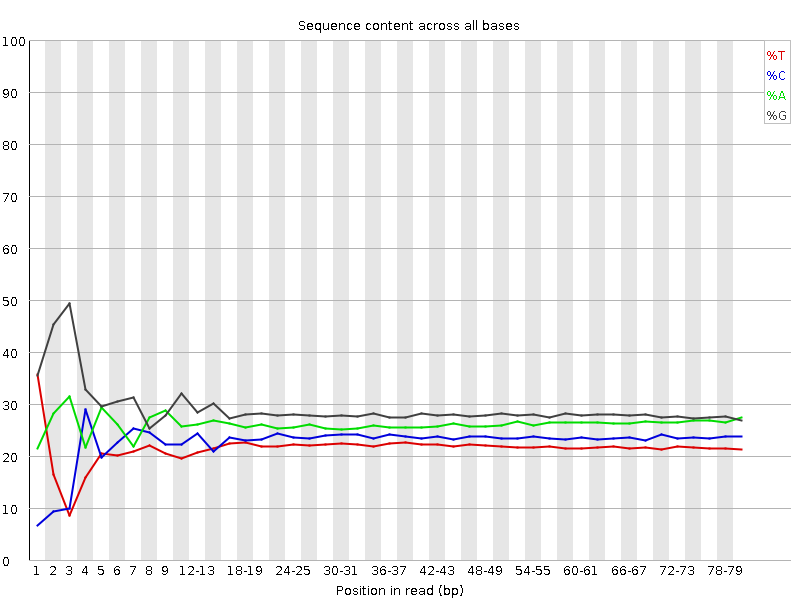

**Per sequence GC content : warn**

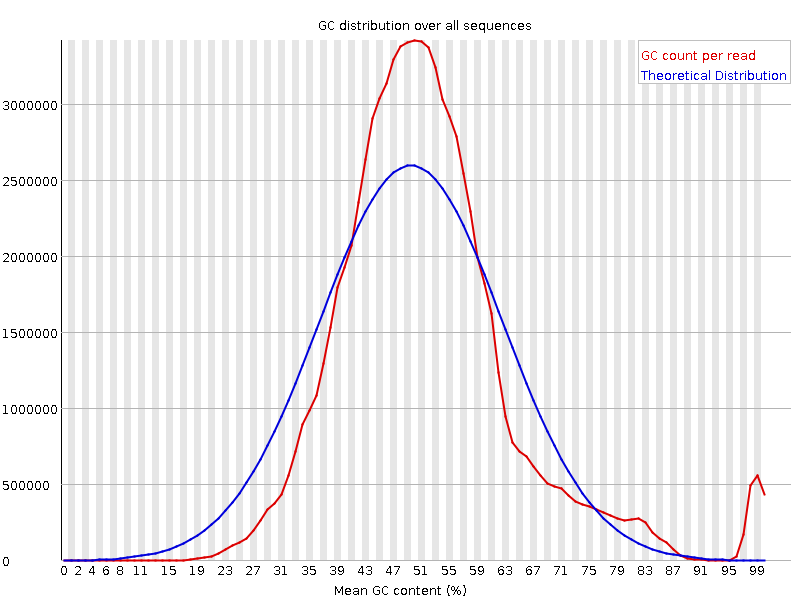

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : warn**

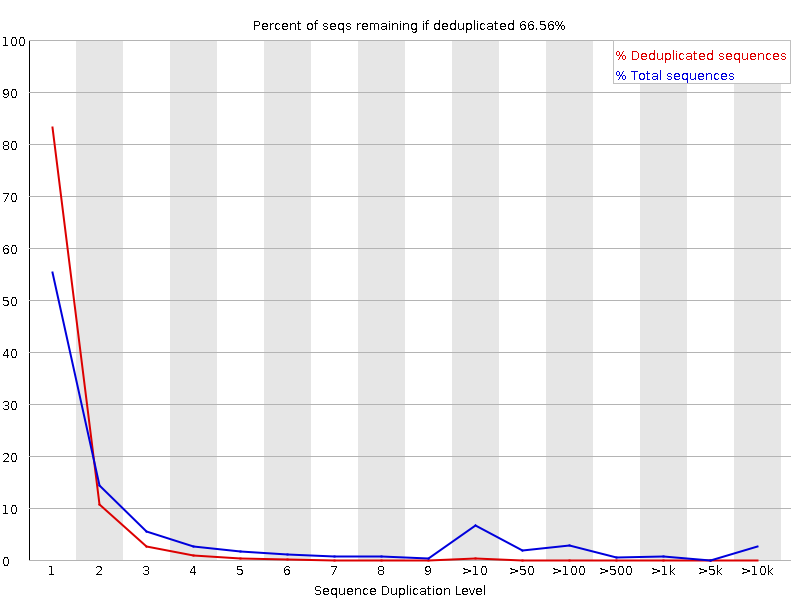

**Overrepresented sequences : warn**

**Adapter Content : warn**

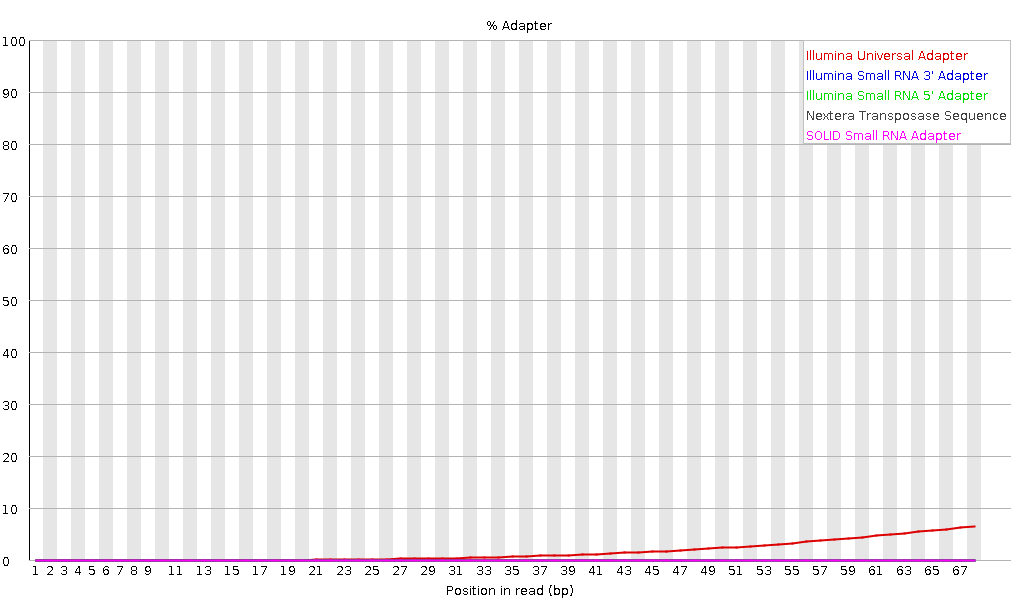

**Kmer Content : fail**

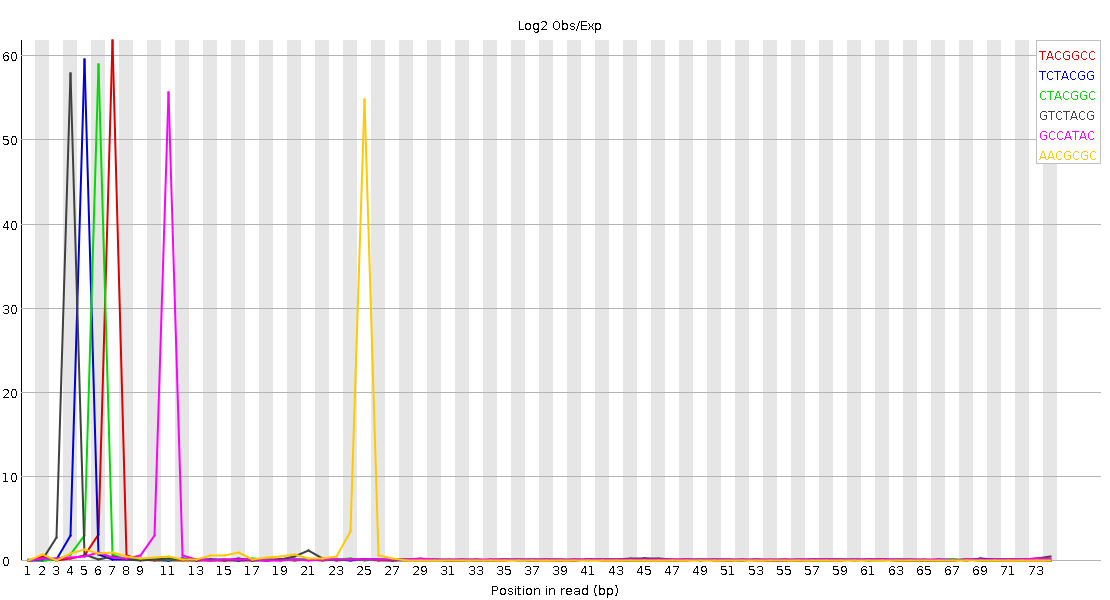

---
## 40IIR_2_fastqc.zip

**Basic Statistics : pass**

**Per base sequence quality : pass**

**Per tile sequence quality : warn**

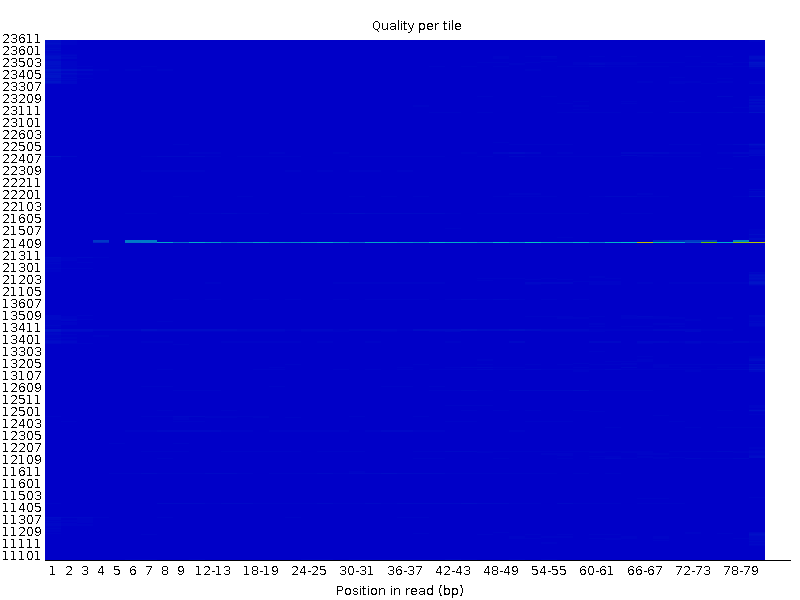

**Per sequence quality scores : pass**

**Per base sequence content : fail**

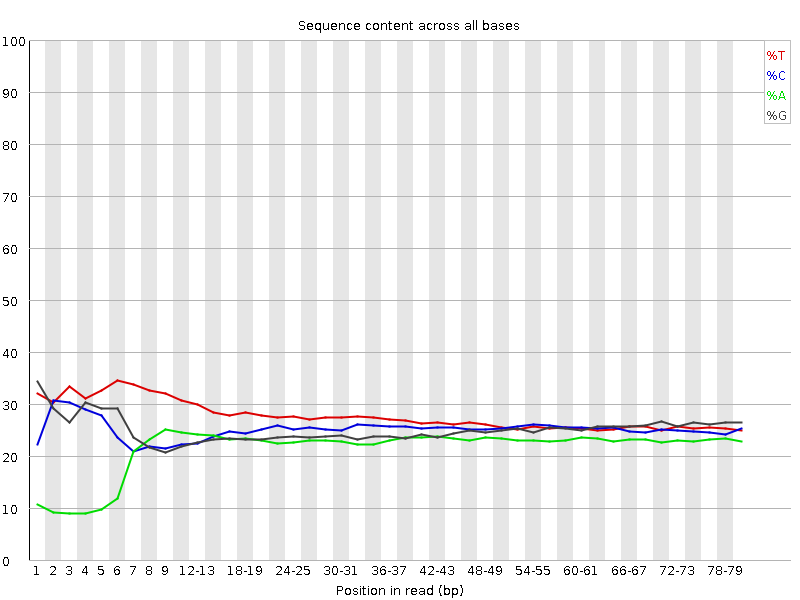

**Per sequence GC content : warn**

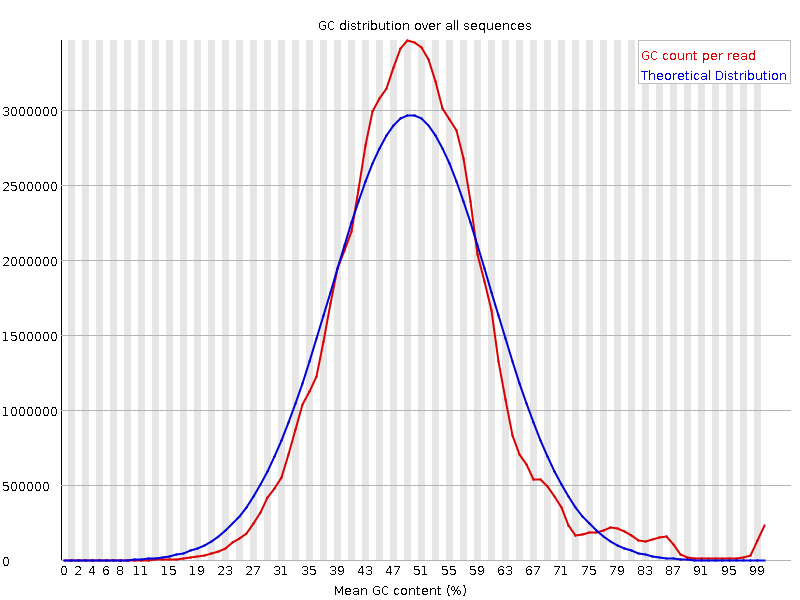

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : fail**

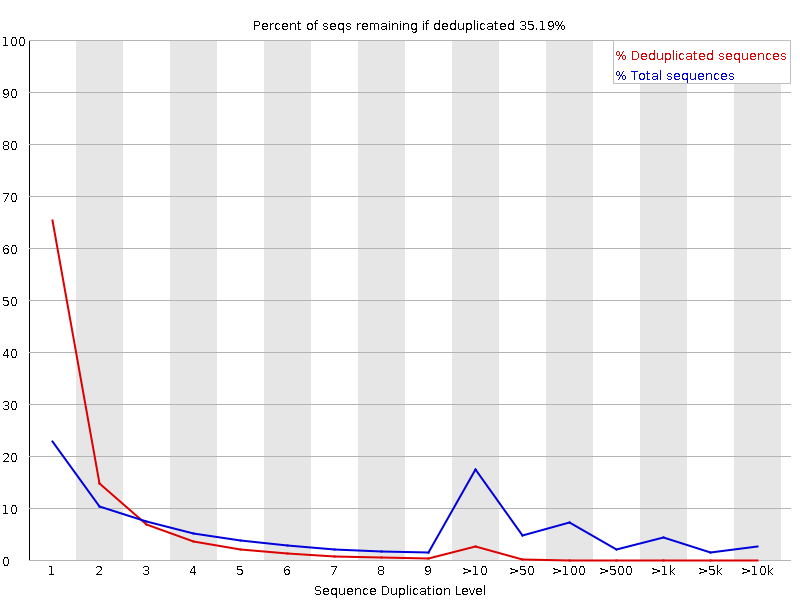

**Overrepresented sequences : warn**

**Adapter Content : warn**

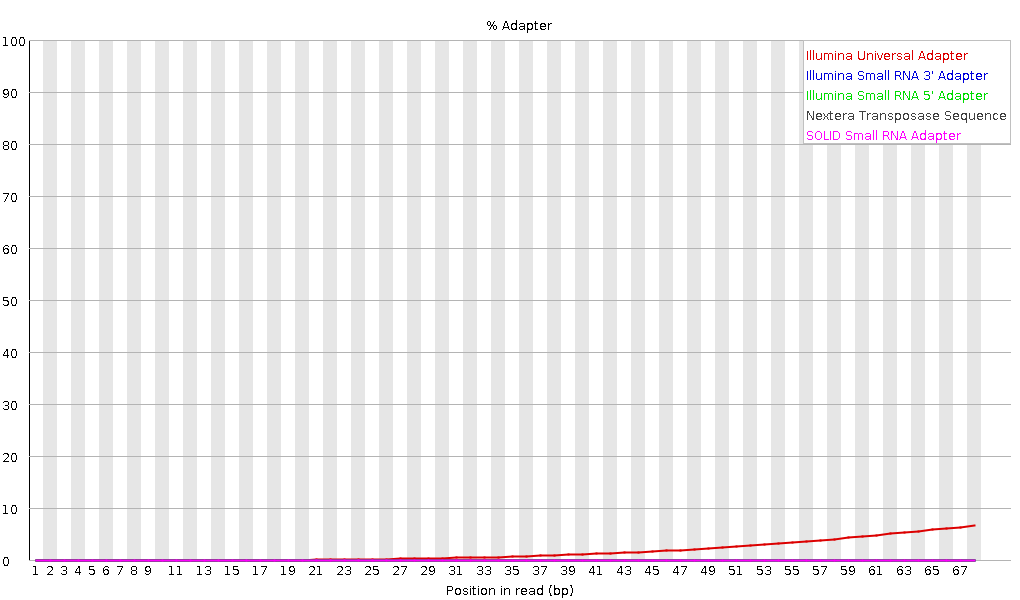

**Kmer Content : fail**

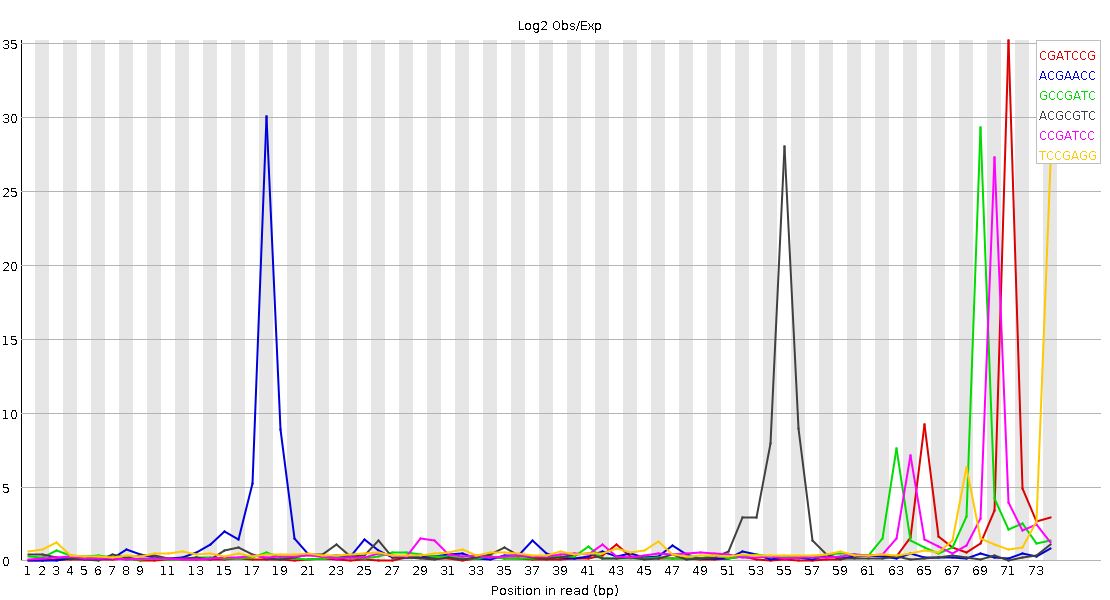

In [2]:
outdir = "./QC/"
pbu.fastqc_summary(outdir, table_if=["pass", "warn", "fail"] , plot_if=["warn", "fail"], max_table_row=10)

The overall quality of the dataset is good, but I found a lot a Overrepresented polyG sequences in all the datasets. The kmer content is also pretty bad. It should not be a problem for the alignment with common RNA aligners

### Alignment with Kalisto quant

In [9]:
# Define a smaller dataset to test alignment
pycl.bash_live("gunzip -c ./data/26IIR_1.fastq.gz | head -n 400000 | gzip -c > ./data/test_1.fa.gz")
pycl.bash_live("gunzip -c ./data/26IIR_2.fastq.gz | head -n 400000 | gzip -c > ./data/test_2.fa.gz")
pycl.bash_live("kallisto-0.43 quant --bias -b 5 --fr-stranded -t 4 -i ./index/gencode_vM10_all_transcripts.idx -o ./alignment/ ./data/test_1.fa.gz ./data/test_2.fa.gz", live="stderr")



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: ./data/test_1.fa.gz
                             ./data/test_2.fa.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 100,000 reads, 79,745 reads pseudoaligned
[quant] estimated average fragment length: 153.705
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 860 rounds
[bstrp] number of EM bootstraps complete: 5



** The rorientation of the reads appears to be fr and not rf as usual...**

In [16]:
# Define parameters
sample_file = "./info/Sample_sheet.tsv"
index_file = "./index/gencode_vM10_all_transcripts.idx"

# read sample sheet
df = pd.read_table(sample_file)

# For each couple of sample 
for id, val in df.iterrows():
    print ("Analysing : {} {}".format(val.stage, val.RNA_sample))
    
    # Prepare the output directory
    outdir = "./alignment/{}_{}/".format(val.stage, val.RNA_sample)
    pycl.mkdir(outdir)
    
    # Prepare the command line
    pycl.bash_live(
        "kallisto-0.43 quant --bias -b 50 --fr-stranded -t 4 -i {} -o {} {} {}".format(index_file, outdir, val.R1_file, val.R2_file),
        live="stderr",
        log_stderr="{}{}_{}_kallisto_report.txt".format(outdir, val.stage, val.RNA_sample))

Analysing : GV-Oocytes 26IIR
Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignment/GV-Oocytes_26IIR



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/26IIR_1.fastq.gz
                             /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/26IIR_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 65,171,330 reads, 50,768,556 reads pseudoaligned
[quant] estimated average fragment length: 152.789
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,352 rounds
[bstrp] number of EM bootstraps complete: 50



Analysing : GV-Oocytes 27IIR
Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignment/GV-Oocytes_27IIR



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/27IIR_1.fastq.gz
                             /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/27IIR_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 59,095,688 reads, 46,575,102 reads pseudoaligned
[quant] estimated average fragment length: 170.308
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,238 rounds
[bstrp] number of EM bootstraps complete: 50



Analysing : GV-Oocytes 42IIR
Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignment/GV-Oocytes_42IIR



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/42IIR_1.fastq.gz
                             /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/42IIR_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 57,954,458 reads, 45,915,565 reads pseudoaligned
[quant] estimated average fragment length: 174.707
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,151 rounds
[bstrp] number of EM bootstraps complete: 50



Analysing : MII-Oocytes 32IIR
Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignment/MII-Oocytes_32IIR



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/32IIR_1.fastq.gz
                             /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/32IIR_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 66,748,506 reads, 51,532,253 reads pseudoaligned
[quant] estimated average fragment length: 148.675
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,225 rounds
[bstrp] number of EM bootstraps complete: 50



Analysing : MII-Oocytes 40IIR
Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignment/MII-Oocytes_40IIR



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/40IIR_1.fastq.gz
                             /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/40IIR_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 68,105,042 reads, 53,662,842 reads pseudoaligned
[quant] estimated average fragment length: 153.386
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,206 rounds
[bstrp] number of EM bootstraps complete: 50



Analysing : MII-Oocytes 41IIR
Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignment/MII-Oocytes_41IIR



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/41IIR_1.fastq.gz
                             /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/41IIR_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 67,864,299 reads, 52,733,298 reads pseudoaligned
[quant] estimated average fragment length: 150.539
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,271 rounds
[bstrp] number of EM bootstraps complete: 50



**Parse the kallisto results**

In [19]:
sample_df = pd.DataFrame(columns = ["Total Reads", "Total read mapped", "% read mapped","Estimated fragment lenght"])
# results obtained with basic alignment using Kallisto quant
for file in glob("./alignment/*/*_kallisto_report.txt"):
    sname = pycl.file_basename(file)[:-16]
    with open (file, "r") as fp: 
        lines = fp.readlines()
        est_len = float(lines[12].split()[-1].replace(",",""))
        total_seq = int(lines[11].split()[2].replace(",",""))
        total_mapped = int(lines[11].split()[4].replace(",",""))
        sample_df.loc[sname]=[total_seq, total_mapped, total_mapped/total_seq*100 , est_len]

sample_df

Total Reads  Total read mapped  % read mapped  \
MII-Oocytes_32IIR   66748506.0         51532253.0      77.203605   
GV-Oocytes_26IIR    65171330.0         50768556.0      77.900138   
GV-Oocytes_42IIR    57954458.0         45915565.0      79.226977   
MII-Oocytes_41IIR   67864299.0         52733298.0      77.704034   
MII-Oocytes_40IIR   68105042.0         53662842.0      78.794228   
GV-Oocytes_27IIR    59095688.0         46575102.0      78.813029   

                   Estimated fragment lenght  
MII-Oocytes_32IIR                    148.675  
GV-Oocytes_26IIR                     152.789  
GV-Oocytes_42IIR                     174.707  
MII-Oocytes_41IIR                    150.539  
MII-Oocytes_40IIR                    153.386  
GV-Oocytes_27IIR                     170.308

** The alignment percentage is decent and very similar between the samples ~ 78 %**

** The length of the fragments is in the range of what is expected with Nextera lib preparation ~ 150 pb**

# Differential expression (DE) analysis with Sleuth

### Generate the sample sheet indicating the kalisto dir for all samples compatible with Sleuth

In [75]:
# Define parameters
sample_sheet = "./info/Sample_sheet.tsv"
kalisto_sample_sheet = "./alignment/kalisto_sample_sheet.tsv"

# read sample sheet
df = pd.read_table(sample_sheet)

with open (kalisto_sample_sheet, "w") as outfile:
    outfile.write("sample\tstage\toocyte\treplicate\tpath\n")
    for id, val in df.iterrows():
        kalisto_path = os.path.abspath("./alignment/{}_{}/".format(val.stage, val.RNA_sample))
        outfile.write("{0}_{1}\t{1}\t{2}\t{3}\t{4}\n".format(val.RNA_sample, val.stage ,val.oocyte, val.replicate ,kalisto_path))

# test the file
pd.read_table(kalisto_sample_sheet)

sample        stage  oocyte  replicate  \
0   26IIR_GV-Oocytes   GV-Oocytes      65          1   
1   27IIR_GV-Oocytes   GV-Oocytes      57          2   
2   42IIR_GV-Oocytes   GV-Oocytes      50          3   
3  32IIR_MII-Oocytes  MII-Oocytes      50          1   
4  40IIR_MII-Oocytes  MII-Oocytes      65          2   
5  41IIR_MII-Oocytes  MII-Oocytes      50          3   

                                                path  
0  /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignme...  
1  /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignme...  
2  /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignme...  
3  /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignme...  
4  /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignme...  
5  /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignme...

### Generate the sample sheet indicating the transcripts to genes correspondance compatible with Sleuth

In [62]:
# Define parameters
gencode_transcripts = "./reference/gencode.vM10.transcripts.tsv"
kallisto_transcript_to_gene = "./alignment/kallisto_transcript_to_gene.tsv"

# read sample sheet
df = pd.read_csv(gencode_transcripts, sep="\t", usecols=[0,1,4,5,6,7], index_col=False)
df.rename(columns={"GENCODE_transcript_id": "target_id", "GENCODE_gene_id": "ens_gene"}, inplace=True)
df.to_csv(kallisto_transcript_to_gene, sep="\t", index=False)

# test the file
pd.read_table(kallisto_transcript_to_gene).head()

target_id              ens_gene    transcript_name  \
0  ENSMUST00000193812.1  ENSMUSG00000102693.1  4933401J01Rik-001   
1  ENSMUST00000082908.1  ENSMUSG00000064842.1        Gm26206-201   
2  ENSMUST00000162897.1  ENSMUSG00000051951.5           Xkr4-003   
3  ENSMUST00000159265.1  ENSMUSG00000051951.5           Xkr4-002   
4  ENSMUST00000070533.4  ENSMUSG00000051951.5           Xkr4-001   

       gene_name  length              RNA_type  
0  4933401J01Rik    1070                   TEC  
1        Gm26206     110                 snRNA  
2           Xkr4    4153  processed_transcript  
3           Xkr4    2989  processed_transcript  
4           Xkr4    3634        protein_coding

## DE analysis with all samples at transcript level

**In this setup I used the following parameters:**
* **transcript to gene corresp**  gencode Vm10
* **Full model** = Differential expression testing on the development stage (the important parameter), the replicate number (dummy to test independance of samples) and oocyte source (dummy to test independance of samples)
* **Boostrap** = 100: All the bootstraps alignments done by Kalisto to compute the true biological variance
* **Sig level** = 0.01: Conservative FDR (usually 0.05) but I also tried with 0.05 and the controls had a lot of false negative
* **Wald** = Wald testing for Differential expression (main test that i will subsequently use)
* **lrt** = likelyhood ratio for Differential expression (just in case)
* **var graph** Variance graph for qc purposes
* Aggregate is not specify indicating that the analysis is done at TRANSCRIPT level.


**My script tests all the cofactor of the full model idependently (stage, replicate, source) and output the following files:**
* **A table containing the differential expression results for each test**. Basically in the table contains 5 important columns:
    * target_id = Encode transcript ID
    * ens_gene = Encode gene ID
    * qval = FDR adjusted pvalue using benjamini-hochberg
    * b = the 'beta' value (analogous to fold change, though technically a bias estimator which has to do with the transformation)
    * mean_obs = the mean expression of each transcript
* **A pdf file containing the plots related to Quality control** (PCA and mean variance)
* **A pdf file containing the plots related to Differential expression** (Volcano plot, MA_plot and QQ plot)

**In all the following results *stageMII-Oocytes* is the beta factor we are interested. It reflects the fold(ish) enrichment in the condition *Stage MII*, The other tests are only controls**

In [171]:
outdir = "./differential_expression/transcript_level/"
pycl.mkdir(outdir)

opt_list = [
    "--s2c ./alignment/kalisto_sample_sheet.tsv",
    "--t2g ./alignment/kallisto_transcript_to_gene.tsv",
    "--outdir ./differential_expression/transcript_level/",
    "--full_model stage+replicate+oocyte",
    "--max_bootstrap 100",
    "--sig_level 0.01",
    "--wald",
    "--lrt",
    "--var_graph"]

cmd = pycl.make_cmd_str("SleuthDEA.R", opt_list=opt_list)
pycl.bash_live(cmd, live="stdout", print_stderr=False, log_stderr=outdir+"sleuth_stderr_out.txt")


### INITIALIZE ###
Parse arguments and import files
Select sample:
	 26IIR_GV-Oocytes 
 	 27IIR_GV-Oocytes 
 	 42IIR_GV-Oocytes 
 	 32IIR_MII-Oocytes 
 	 40IIR_MII-Oocytes 
 	 41IIR_MII-Oocytes 

Running with the following options:
	s2: c ./alignment/kalisto_sample_sheet.tsv 
	t2g:  ./alignment/kallisto_transcript_to_gene.tsv 
	outdir:  ./differential_expression/transcript_level/ 
	select_col:  
	select_val:  
	full_model:  stage+replicate+oocyte 
	max_bootstrap:  100 
	no_norm:  FALSE 
	min_est:  5 
	min_prop:  0.47 
	aggreg_col:  FALSE 
	threads:  1 
	sig_level:  0.01 
	wald:  TRUE 
	lrt:  TRUE 
	var_graph:  TRUE 
	rds:  FALSE 

### SLEUTH ANALYSIS ###
Extract the data from the kalisto results and normalise
Estimate parameters for the sleuth response error measurement (full) model
Estimate parameters for the sleuth reduced model (shrinkage)
Performing Wald test for all cofactors
	Analysing cofactor: (Intercept) 
		Generate tables and plots
		Significant genes:  19972 
		Significant 

### Interpretation of the results

**For the oocyte stage comparison, the following results were obtained **

    Significant transcript:  2376 
    Significant transcript enriched:  1508 
    Significant transcript depleted:  868  

**The 2 controls also have some significant gene, indicating a non independance of the samples, or more likely a high variability between replicates (see PCA results)**
    
    Significant transcripts replicates:  214 
    Significant genes oocytes:  18
    
** Although I used a conservative FDR, this represents a lot of transcripts diferentially expressed. One should keep in mind that the replicates seems quite variable which as shown by the number of differentially expressed transcripts between the replacates as well as the PCA plot in the pdf file generated by SleuthDEA.R. One solution might be to use a more conservative FDR, 0.001? **

## Further analysis by transcript type

**To try to get some functional differences in the transcriptome, I ploted below the a volcano plot, a MA plot and a density curve plot, an highlited the transcript by their types as annotated in gencode (see http://www.gencodegenes.org/gencode_biotypes.html).**

In [29]:
def plot_transcript_data (DE_file, gene_file, FDR=1, min_RNA_type=20):
    
    # Import in dataframe
    DE_df = pd.read_csv (DE_file, sep="\t")
    DE_df_significant = DE_df[(DE_df.qval <= FDR)]
    gene_df = pd.read_csv (gene_file, sep="\t", index_col=False)

    # Merge the 2 dataframes togetherb
    df = pd.merge(gene_df, DE_df, how="inner", left_on="GENCODE_transcript_id", right_on="target_id")

    # Index by gene name and transcript name and clean
    df.drop(["HAVANA_gene_id", "HAVANA_transcript_id", "ens_gene", "GENCODE_transcript_id", "transcript_name_y", "gene_name_y"], axis=1, inplace=True)
    df.dropna(inplace=True)

    # Get the transcript id per RNA class 
    hl=[]
    for RNA_type, transcript_df in df.groupby("RNA_type"):
        transcript_df = transcript_df[(transcript_df.qval <= FDR)]
        if len(transcript_df) >= min_RNA_type:
            hl.append({"target_id": transcript_df.target_id, "label": RNA_type, "alpha":0.75, "linestyle":"--"})
    hl.sort(key = lambda x: len(x["target_id"]), reverse=True)

    # Volcano plot with transcript type highlight
    pbp.volcano_plot (df=DE_df, highlight_list=hl, X="b", Y="qval", FDR=FDR, X_cutoff=0, figsize=[30,10], xlim=[-7,7], ylim=[0,50], sig_color="0.5", non_sig_color="0.9",
                  xlabel = "<< Enriched at GV stage << - Beta factor - >> Enriched at MII stage >>", ylabel = "-log10(qval)")
    pbp.MA_plot (df=DE_df, highlight_list=hl, X="mean_obs", Y="b", FDR=FDR, FDR_col="qval", figsize=[30,10], alpha=0.5, ylim=[-10,10], sig_color="0.5", non_sig_color="0.9",
                 xlabel="Mean expression", ylabel="<< Enriched at GV stage << - Beta factor - >> Enriched at MII stage >>") 
    pbp.density_plot(DE_df_significant, "b", figsize=[30,10], ylabel="Cumulative Enrichment in MII condition", highlight_list= hl, cumulative = True)

### Plot without FDR limit

using a non-integer number instead of an integer will result in an error in the future


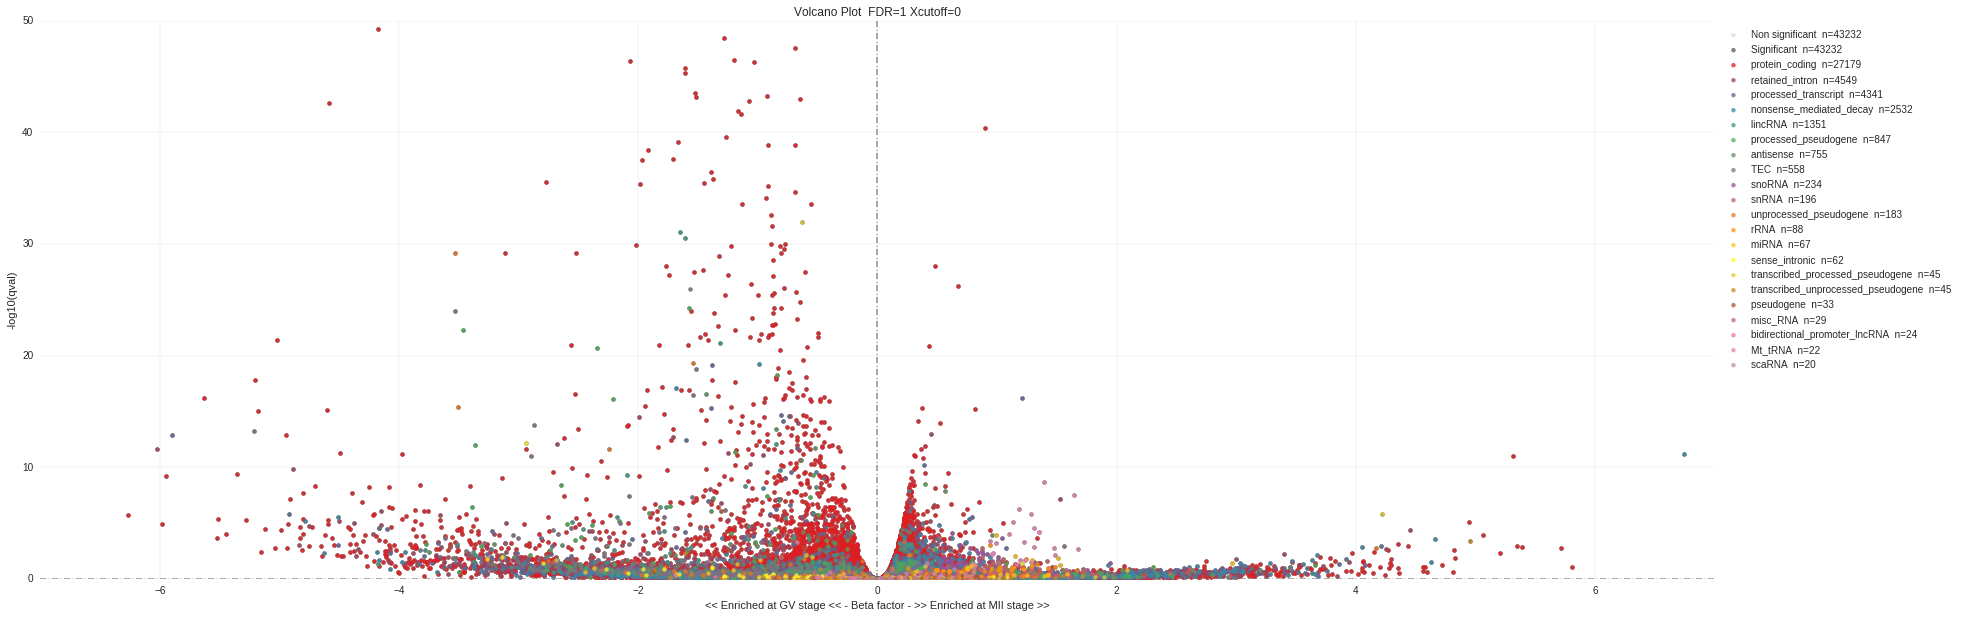

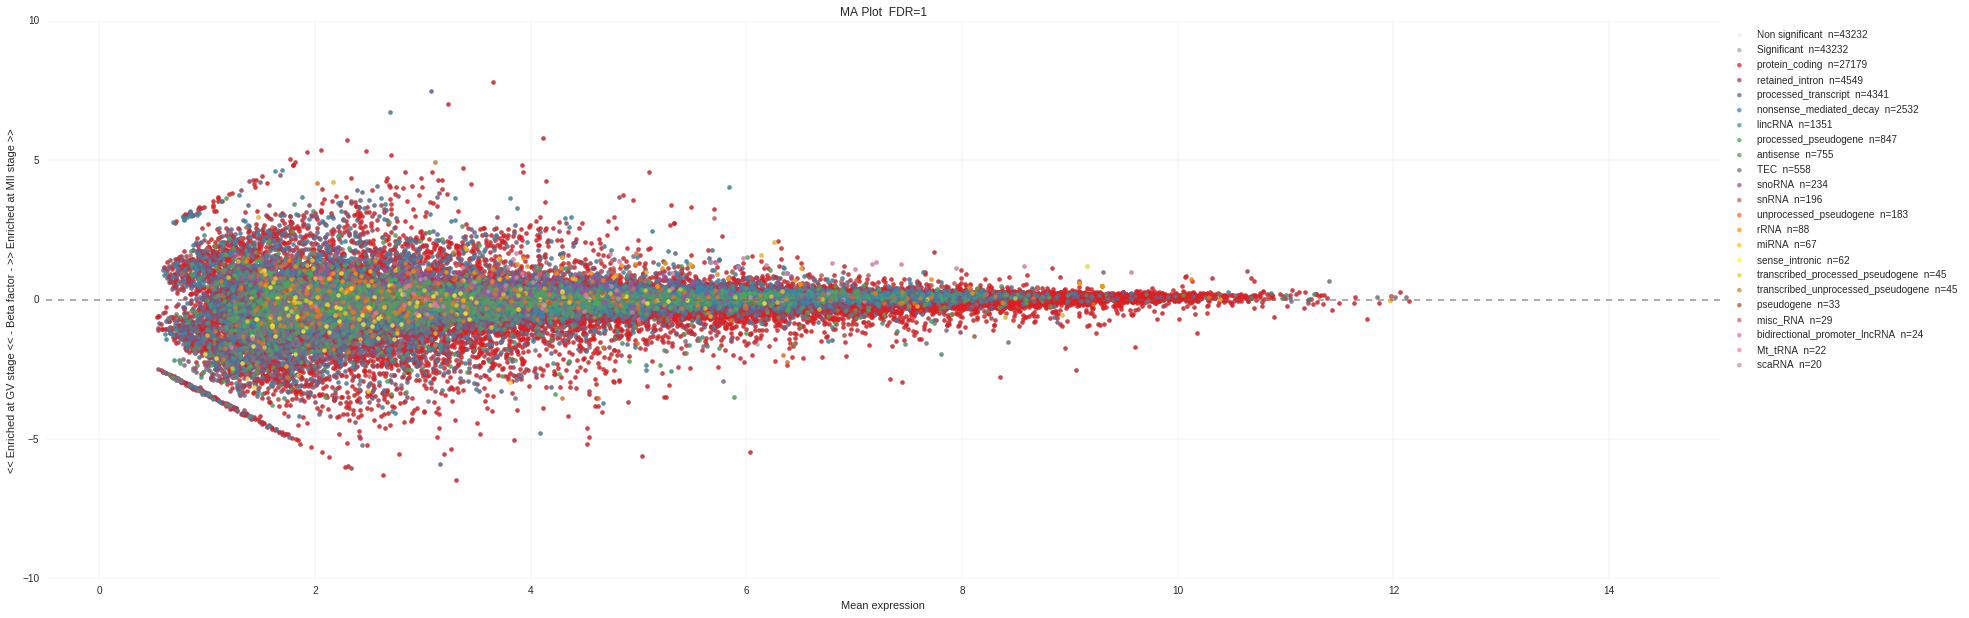

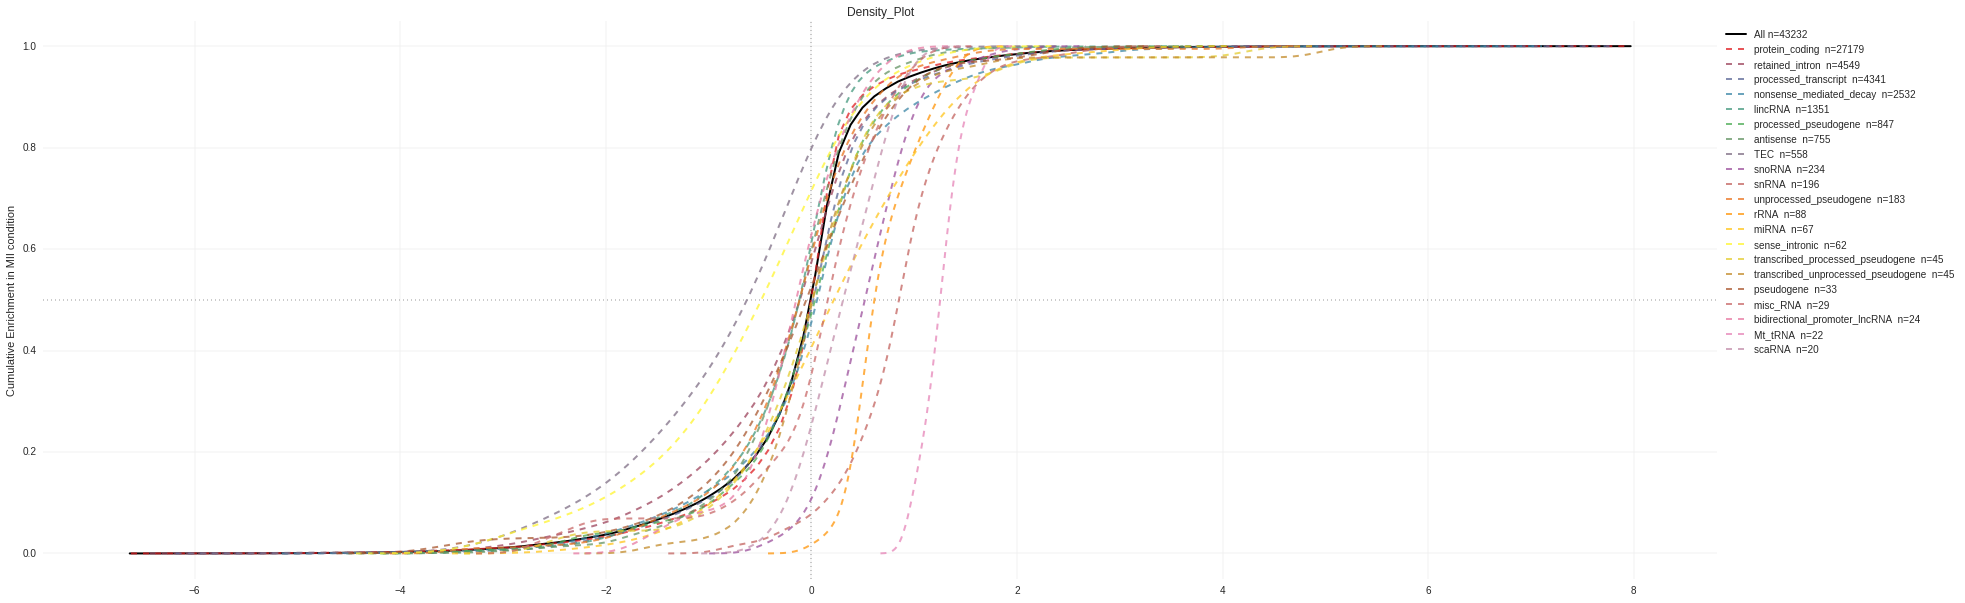

In [30]:
plot_transcript_data (
    DE_file = "./differential_expression/transcript_level/stageMII-Oocytes_wald_test.tsv",
    gene_file = "./reference/gencode.vM10.transcripts.tsv",
    min_RNA_type = 20)

Many biotype of RNA where found in the dataset including protein coding, retained introns, process transcript (lncRNA), nonsense mediated decay, lincRNA...  

Some biotype of RNA seems to be enriched in at GV stage or at MII stage, but the corresponding categories are usually expressed at low level. I need to threshold with the FDR (low pvalue) to remove transcripts which enrichment in GV or MII is uncertain 

### Plot with the filtering FDR = 0.01 : Remove RNA with uncertain enrichment and low expression

* Grey points in volcano and MA plots = non significants transcripts
* S curve density plot = only significant transcripts

using a non-integer number instead of an integer will result in an error in the future


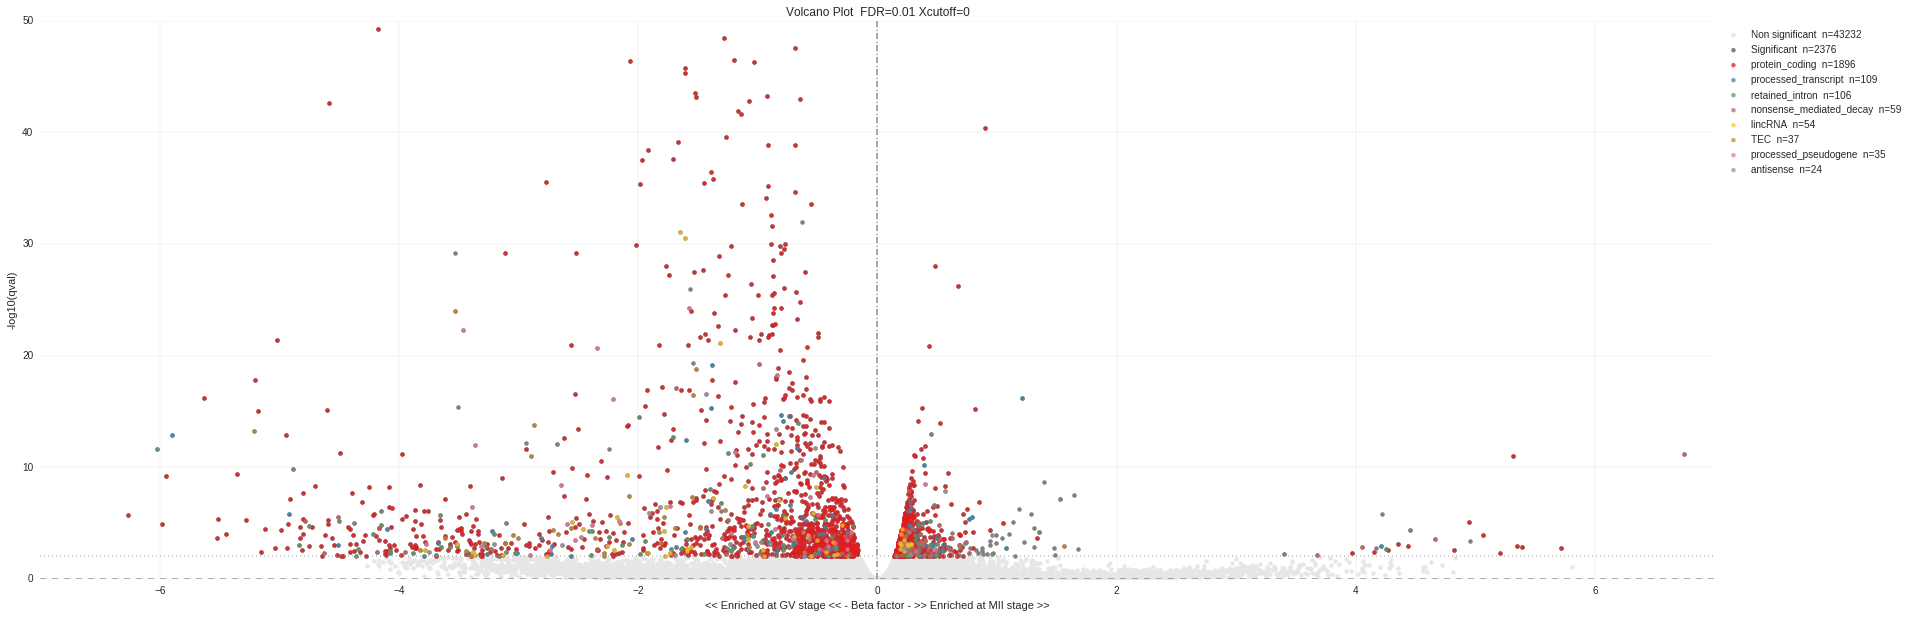

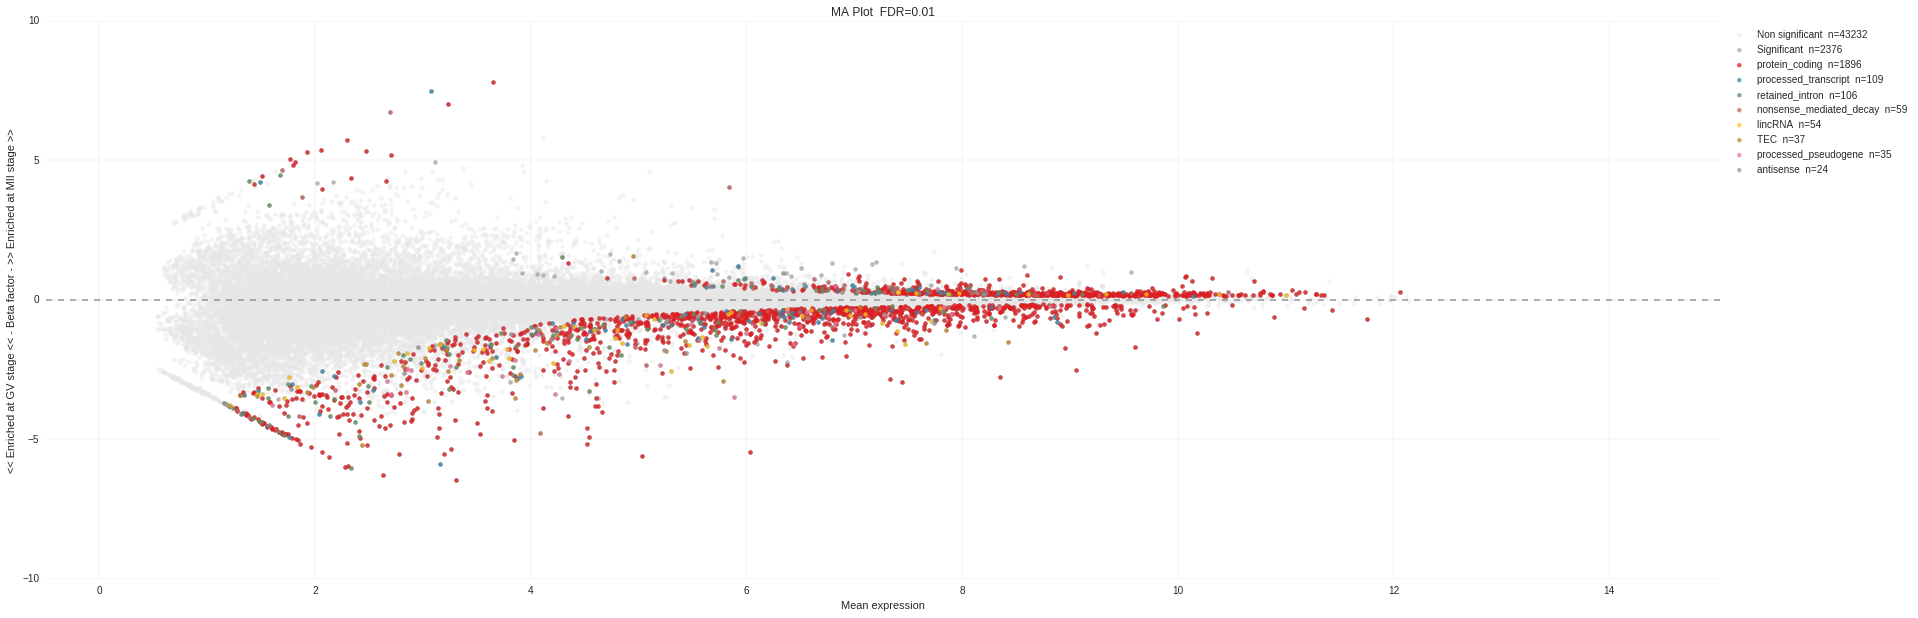

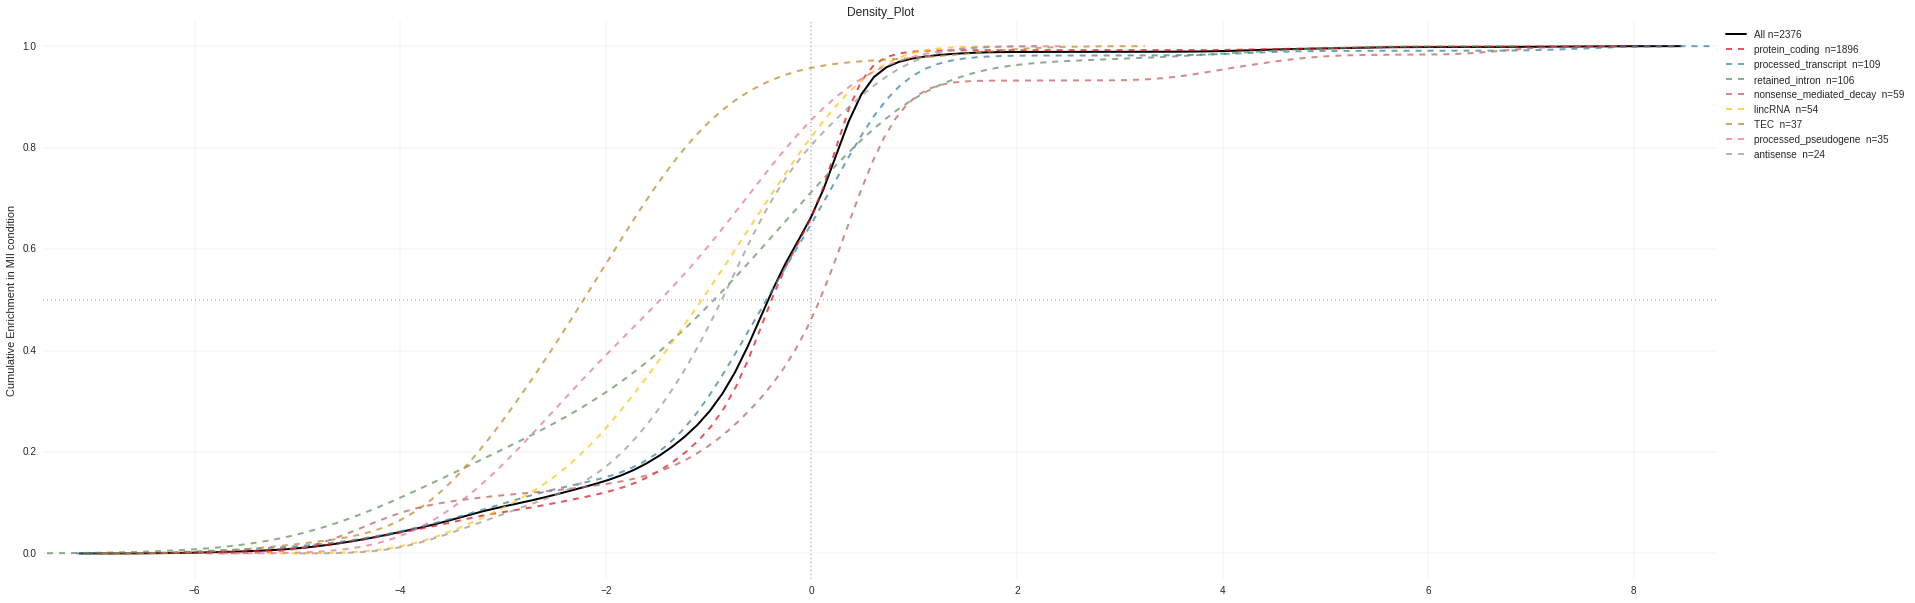

In [31]:
plot_transcript_data (
    DE_file = "./differential_expression/transcript_level/stageMII-Oocytes_wald_test.tsv",
    gene_file = "./reference/gencode.vM10.transcripts.tsv",
    FDR=0.01,
    min_RNA_type = 20)

When thresholding with the FDR at 0.01, Many classes of RNA are eliminated, mainly the short RNA classes and the classes with low expression or represented by few candidates.

* At GV stage, TEC, lincRNA, processed pseudogenes and retained introns seems to be enriched.
* At MII stage only the non sense mediated decay are enriched.

From a general point of view, there are more RNA transcripts significantly enriched at GV stage than at MII stage.

## DE analysis with all samples at gene level

** Similar than previously, but a aggregation step is performed by sleuth to group transcripts of the same gene together**

In [32]:
outdir = "./differential_expression/gene_level/"
pycl.mkdir(outdir)

opt_list = [
    "--s2c ./alignment/kalisto_sample_sheet.tsv",
    "--t2g ./alignment/kallisto_transcript_to_gene.tsv",
    "--outdir ./differential_expression/gene_level/",
    "--full_model stage+replicate+oocyte",
    "--max_bootstrap 100",
    "--sig_level 0.01",
    "--threads 4",
    "--aggreg_col",
    "--wald",
    "--lrt",
    "--var_graph"]

cmd = pycl.make_cmd_str("SleuthDEA.R", opt_list=opt_list)
pycl.bash_live(cmd, live="stdout", print_stderr=False, log_stderr=outdir+"sleuth_stderr_out.txt")


### INITIALIZE ###
Parse arguments and import files
Select sample:
	 26IIR_GV-Oocytes 
 	 27IIR_GV-Oocytes 
 	 42IIR_GV-Oocytes 
 	 32IIR_MII-Oocytes 
 	 40IIR_MII-Oocytes 
 	 41IIR_MII-Oocytes 

### SLEUTH ANALYSIS ###
Extract the data from the kalisto results and normalise
Estimate parameters for the sleuth response error measurement (full) model
Estimate parameters for the sleuth reduced model (shrinkage)
Performing Wald test for all cofactors
	Analysing cofactor: (Intercept) 
		Generate tables and plots
		Significant genes:  12842 
		Significant genes enriched:  8 
		Significant genes depleted:  12834 
	Analysing cofactor: stageMII-Oocytes 
		Generate tables and plots
		Significant genes:  2695 
		Significant genes enriched:  1664 
		Significant genes depleted:  1031 
	Analysing cofactor: replicate 
		Generate tables and plots
		Significant genes:  309 
		Significant genes enriched:  178 
		Significant genes depleted:  131 
	Analysing cofactor: oocyte 
		Generate tables and plots


### Interpretation of the results

**As for transcripts, I also get a lot of deregulated genes and a variability between samples** 

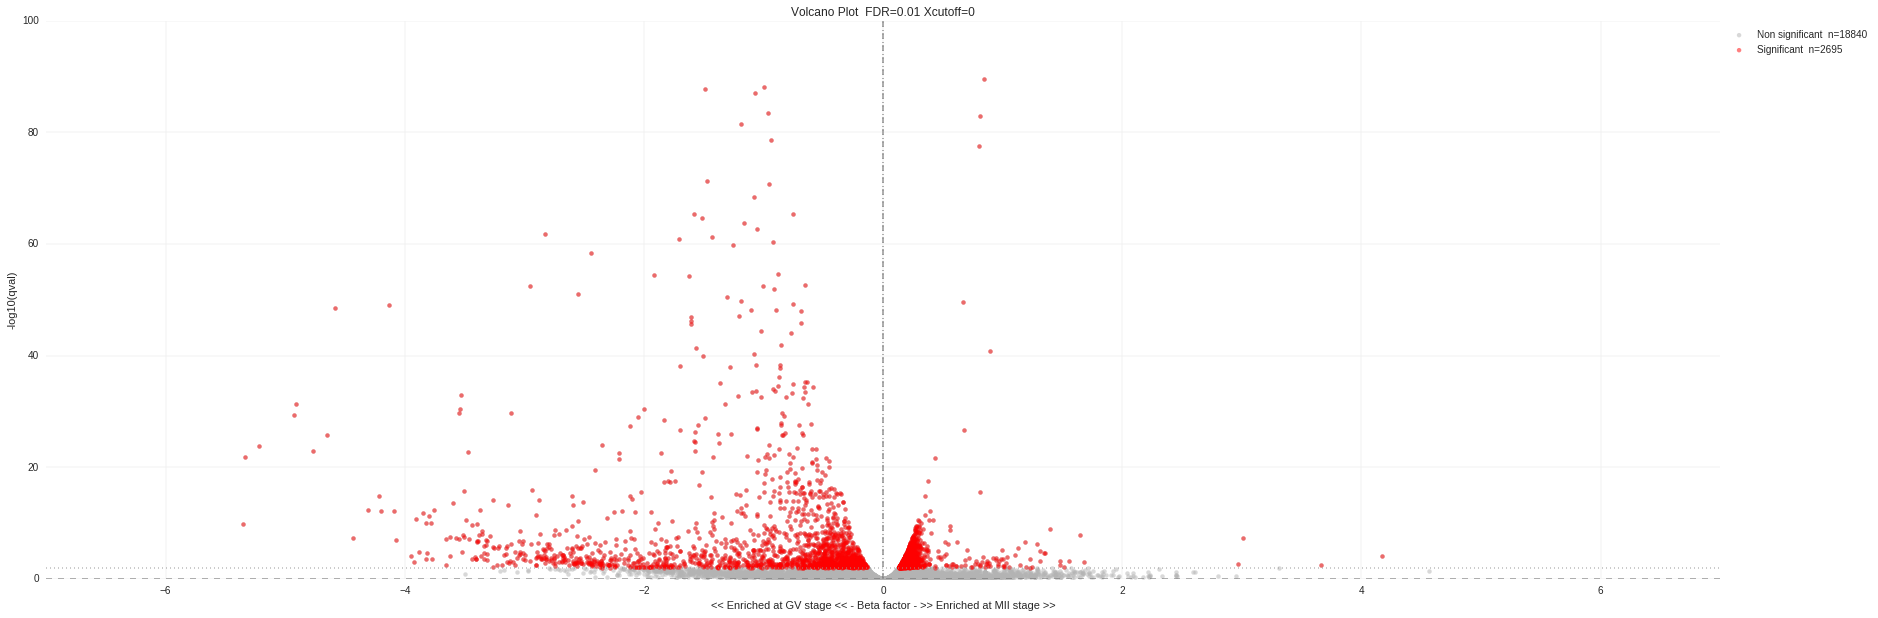

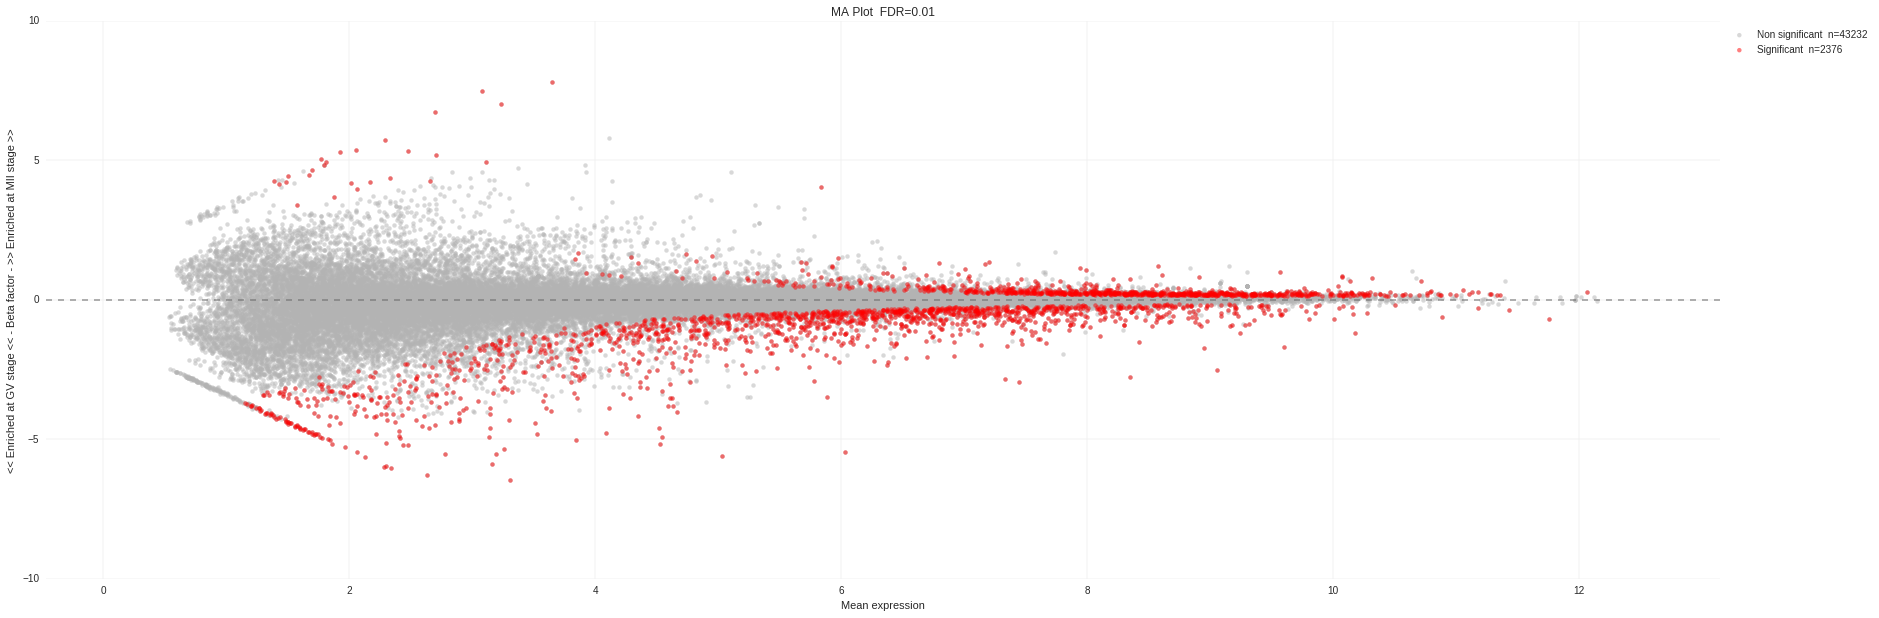

In [6]:
# Define files
DE_file = "./differential_expression/gene_level/stageMII-Oocytes_wald_test.tsv"
DE_df = pd.read_csv (DE_file, sep="\t")

# Volcano plot with transcript type highlight
pbp.volcano_plot (df=DE_df, X="b", Y="qval", FDR=0.01, X_cutoff=0, figsize=[30,10], xlim=[-7,7], ylim=[0,100], sig_color="red", alpha=0.5,
                  xlabel = "<< Enriched at GV stage << - Beta factor - >> Enriched at MII stage >>", ylabel = "-log10(qval)")
pbp.MA_plot (df=df, X="mean_obs", Y="b", FDR=0.01, FDR_col="qval", figsize=[30,10], ylim=[-10,10], sig_color="red", alpha=0.5,
             xlabel="Mean expression", ylabel="<< Enriched at GV stage << - Beta factor - >> Enriched at MII stage >>")